In [5]:
!pip install --upgrade riskoptima

In [1]:
import pandas as pd
from riskoptima import RiskOptima

import warnings
warnings.filterwarnings(
    "ignore", 
    category=FutureWarning, 
    message=".*DataFrame.std with axis=None is deprecated.*"
)

# Define your current porfolio with your weights and company names
asset_data = [
    {"Asset": "MO",    "Weight": 0.04, "Label": "Altria Group Inc.",       "MarketCap": 110.0e9},
    {"Asset": "NWN",   "Weight": 0.14, "Label": "Northwest Natural Gas",   "MarketCap": 1.8e9},
    {"Asset": "BKH",   "Weight": 0.01, "Label": "Black Hills Corp.",         "MarketCap": 4.5e9},
    {"Asset": "ED",    "Weight": 0.01, "Label": "Con Edison",                "MarketCap": 30.0e9},
    {"Asset": "PEP",   "Weight": 0.09, "Label": "PepsiCo Inc.",              "MarketCap": 255.0e9},
    {"Asset": "NFG",   "Weight": 0.16, "Label": "National Fuel Gas",         "MarketCap": 5.6e9},
    {"Asset": "KO",    "Weight": 0.06, "Label": "Coca-Cola Company",         "MarketCap": 275.0e9},
    {"Asset": "FRT",   "Weight": 0.28, "Label": "Federal Realty Inv. Trust", "MarketCap": 9.8e9},
    {"Asset": "GPC",   "Weight": 0.16, "Label": "Genuine Parts Co.",         "MarketCap": 25.3e9},
    {"Asset": "MSEX",  "Weight": 0.05, "Label": "Middlesex Water Co.",       "MarketCap": 2.4e9}
]
asset_table = pd.DataFrame(asset_data)

capital = 100_000

asset_table['Portfolio'] = asset_table['Weight'] * capital

ANALYSIS_START_DATE = RiskOptima.get_previous_year_date(RiskOptima.get_previous_working_day(), 1)
ANALYSIS_END_DATE   = RiskOptima.get_previous_working_day()
BENCHMARK_INDEX     = 'SPY'
RISK_FREE_RATE      = 0.05
NUMBER_OF_WEIGHTS   = 10_000
NUMBER_OF_MC_RUNS   = 1_000

print(asset_table)
print(RiskOptima.VERSION)

  Asset  Weight                      Label     MarketCap  Portfolio
0    MO    0.04          Altria Group Inc.  1.100000e+11     4000.0
1   NWN    0.14      Northwest Natural Gas  1.800000e+09    14000.0
2   BKH    0.01          Black Hills Corp.  4.500000e+09     1000.0
3    ED    0.01                 Con Edison  3.000000e+10     1000.0
4   PEP    0.09               PepsiCo Inc.  2.550000e+11     9000.0
5   NFG    0.16          National Fuel Gas  5.600000e+09    16000.0
6    KO    0.06          Coca-Cola Company  2.750000e+11     6000.0
7   FRT    0.28  Federal Realty Inv. Trust  9.800000e+09    28000.0
8   GPC    0.16          Genuine Parts Co.  2.530000e+10    16000.0
9  MSEX    0.05        Middlesex Water Co.  2.400000e+09     5000.0
1.41.0


In [25]:
import pandas as pd
import numpy as np
import scipy.stats as si
import statsmodels.api as sm
import math
import yfinance as yf
from scipy.stats import norm
from scipy.optimize import minimize
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from xgboost import XGBRegressor
from sklearn.svm import SVR
from datetime import date, datetime, timedelta
import seaborn as sns
from matplotlib.ticker import MultipleLocator, MaxNLocator
from matplotlib.dates import DateFormatter
from matplotlib.dates import AutoDateLocator
import matplotlib.patches as patches
import squarify
import matplotlib as mpl
import matplotlib.ticker as mticker
import os

In [53]:
def run_sma_strategy_with_risk(ticker: str, start: str, end: str, stop_loss: float = None, take_profit: float = None):
    
    df = yf.download(ticker, start=start, end=end, progress=False)[['Close']].copy()
    
    df['SMA20'] = df['Close'].rolling(20).mean()
    df['SMA50'] = df['Close'].rolling(50).mean()

    df['Signal'] = 0
    df.loc[df.index[50]:, 'Signal'] = (
        (df['SMA20'][50:] > df['SMA50'][50:]) & 
        (df['SMA20'].shift(1)[50:] <= df['SMA50'].shift(1)[50:])
    ).astype(int) - (
        (df['SMA20'][50:] < df['SMA50'][50:]) & 
        (df['SMA20'].shift(1)[50:] >= df['SMA50'].shift(1)[50:])
    ).astype(int)

    trades = []
    position = None
    entry_price = None
    entry_date = None

    for exit_date, row in df.iterrows():
        price = row['Close'].item() if hasattr(row['Close'], 'item') else float(row['Close'])
        signal = row['Signal'].item() if hasattr(row['Signal'], 'item') else int(row['Signal'])

        if position is None and signal == 1:
            position = 'long'
            entry_price = price
            entry_date = exit_date

        elif position == 'long':
            pnl = (price - entry_price) / entry_price
            hit_stop = stop_loss is not None and pnl <= -stop_loss
            hit_take = take_profit is not None and pnl >= take_profit

            if signal == -1 or hit_stop or hit_take:
                trades.append({
                    'Ticker': ticker,
                    'Entry Date': entry_date,
                    'Exit Date': exit_date,
                    'Entry Price': entry_price,
                    'Exit Price': price,
                    'Return': pnl,
                    'Exit Reason': (
                        'Sell Signal' if signal == -1 else
                        'Stop Loss' if hit_stop else
                        'Take Profit'
                    )
                })
                position = None

    return pd.DataFrame(trades)

def run_strategy_on_portfolio(asset_table: pd.DataFrame, start: str, end: str,
                              stop_loss: float = None, take_profit: float = None):
    results = []
    print(asset_table)
    for _, row in asset_table.iterrows():
        ticker = row['Asset']
        weight = row['Weight']
        trades_df = run_sma_strategy_with_risk(
            ticker, start, end,
            stop_loss=stop_loss, take_profit=take_profit
        )
        trades_df['Weight'] = weight
        trades_df['Weighted Return'] = trades_df['Return'] * weight
        results.append(trades_df)

    all_trades = pd.concat(results).sort_values(by='Entry Date')
    return all_trades

def plot_sma_strategy_cumulative_return(trade_log: pd.DataFrame, title="Portfolio Return"):
    trade_log = trade_log.sort_values('Exit Date').copy()
    trade_log['Cumulative Return'] = (1 + trade_log['Weighted Return']).cumprod()

    fig, ax = plt.subplots(figsize=(20, 12))
    
    plt.plot(trade_log['Exit Date'], trade_log['Cumulative Return'], marker='o')
    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel("Cumulative Return")
    plt.grid(alpha=0.3)
    
    plt.text(
        0.995, -0.20, f"Created by RiskOptima v{RiskOptima.VERSION}",
        fontsize=12, color='gray', alpha=0.7, transform=ax.transAxes, ha='right'
    )
    
    plt.tight_layout()
    
    plots_folder = "plots"
    
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

    if not os.path.exists(plots_folder):
        os.makedirs(plots_folder)

    plot_path = os.path.join(plots_folder, f"riskoptima_sma_strategy_cum_ret_{timestamp}.png")

    plt.savefig(plot_path, dpi=150, bbox_inches='tight')
    plt.show()
    
def plot_sma_strategy_trades(df: pd.DataFrame, ticker: str):
    fig, ax = plt.subplots(figsize=(20, 12))
    plt.plot(df.index, df['Close'], label='Close Price', alpha=0.5)
    plt.plot(df.index, df['SMA20'], label='SMA20', alpha=0.8)
    plt.plot(df.index, df['SMA50'], label='SMA50', alpha=0.8)

    plt.scatter(df.index[df['Signal'] == 1], df['Close'][df['Signal'] == 1],
                marker='^', color='green', s=100, label='Buy Signal')
    plt.scatter(df.index[df['Signal'] == -1], df['Close'][df['Signal'] == -1],
                marker='v', color='red', s=100, label='Sell Signal')

    plt.title(f"{ticker} - SMA Strategy with Signals")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(alpha=0.3)
    
    plt.text(
        0.995, -0.20, f"Created by RiskOptima v{RiskOptima.VERSION}",
        fontsize=12, color='gray', alpha=0.7, transform=ax.transAxes, ha='right'
    )
    
    plt.tight_layout()
    
    plots_folder = "plots"
    
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

    if not os.path.exists(plots_folder):
        os.makedirs(plots_folder)

    plot_path = os.path.join(plots_folder, f"riskoptima_sma_strategy_{timestamp}.png")

    plt.savefig(plot_path, dpi=150, bbox_inches='tight')
    
    plt.show()
    
def run_and_plot_sma_strategy(tickers, start_date, end_date, stop_loss=None, take_profit=None):
    # Normalize input
    if isinstance(tickers, str):
        asset_table = pd.DataFrame([{"Asset": tickers, "Weight": 1.0}])
    elif isinstance(tickers, list):
        asset_table = pd.DataFrame([{"Asset": t, "Weight": 1.0 / len(tickers)} for t in tickers])
    elif isinstance(tickers, pd.DataFrame):
        asset_table = tickers.copy()
    else:
        raise ValueError("Tickers must be a string, list, or DataFrame.")

    # Run portfolio strategy
    portfolio_trades = run_strategy_on_portfolio(
        asset_table, start=start_date, end=end_date,
        stop_loss=stop_loss, take_profit=take_profit
    )

    # If only one ticker, also show price chart with signals
    if len(asset_table) == 1:
        ticker = asset_table.iloc[0]['Asset']
        df = yf.download(ticker, start=start_date, end=end_date, progress=False)[['Close']]
        df['SMA20'] = df['Close'].rolling(20).mean()
        df['SMA50'] = df['Close'].rolling(50).mean()
        df['Signal'] = 0
        df.loc[df.index[50]:, 'Signal'] = (
            (df['SMA20'][50:] > df['SMA50'][50:]) & 
            (df['SMA20'].shift(1)[50:] <= df['SMA50'].shift(1)[50:])
        ).astype(int) - (
            (df['SMA20'][50:] < df['SMA50'][50:]) & 
            (df['SMA20'].shift(1)[50:] >= df['SMA50'].shift(1)[50:])
        ).astype(int)

        plot_sma_strategy_trades(df, ticker)

    # Always plot cumulative return
    plot_sma_strategy_cumulative_return(portfolio_trades, title="SMA Strategy - Cumulative Return")

    return portfolio_trades

  Asset  Weight                      Label     MarketCap  Portfolio
0    MO    0.04          Altria Group Inc.  1.100000e+11     4000.0
1   NWN    0.14      Northwest Natural Gas  1.800000e+09    14000.0
2   BKH    0.01          Black Hills Corp.  4.500000e+09     1000.0
3    ED    0.01                 Con Edison  3.000000e+10     1000.0
4   PEP    0.09               PepsiCo Inc.  2.550000e+11     9000.0
5   NFG    0.16          National Fuel Gas  5.600000e+09    16000.0
6    KO    0.06          Coca-Cola Company  2.750000e+11     6000.0
7   FRT    0.28  Federal Realty Inv. Trust  9.800000e+09    28000.0
8   GPC    0.16          Genuine Parts Co.  2.530000e+10    16000.0
9  MSEX    0.05        Middlesex Water Co.  2.400000e+09     5000.0


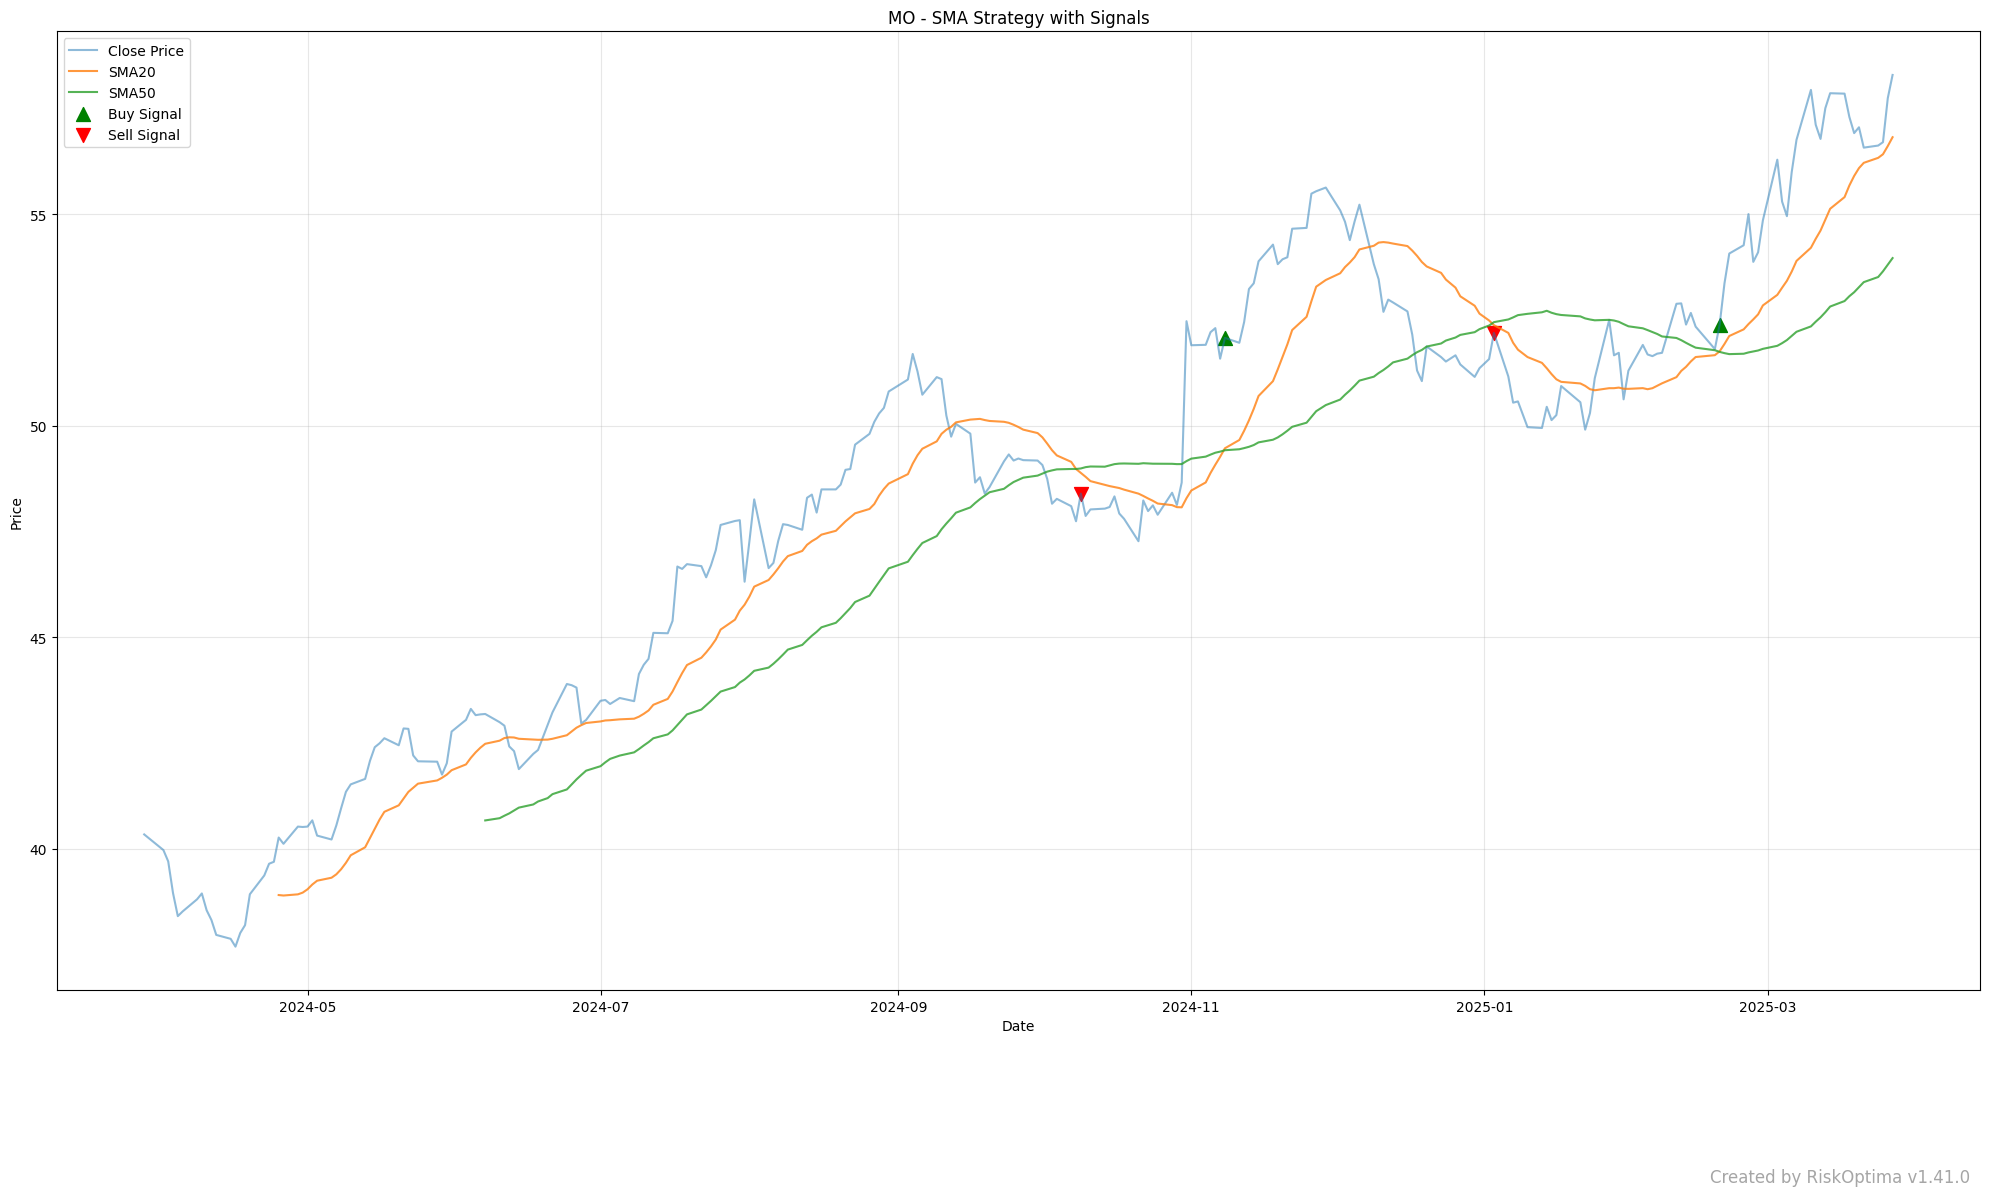

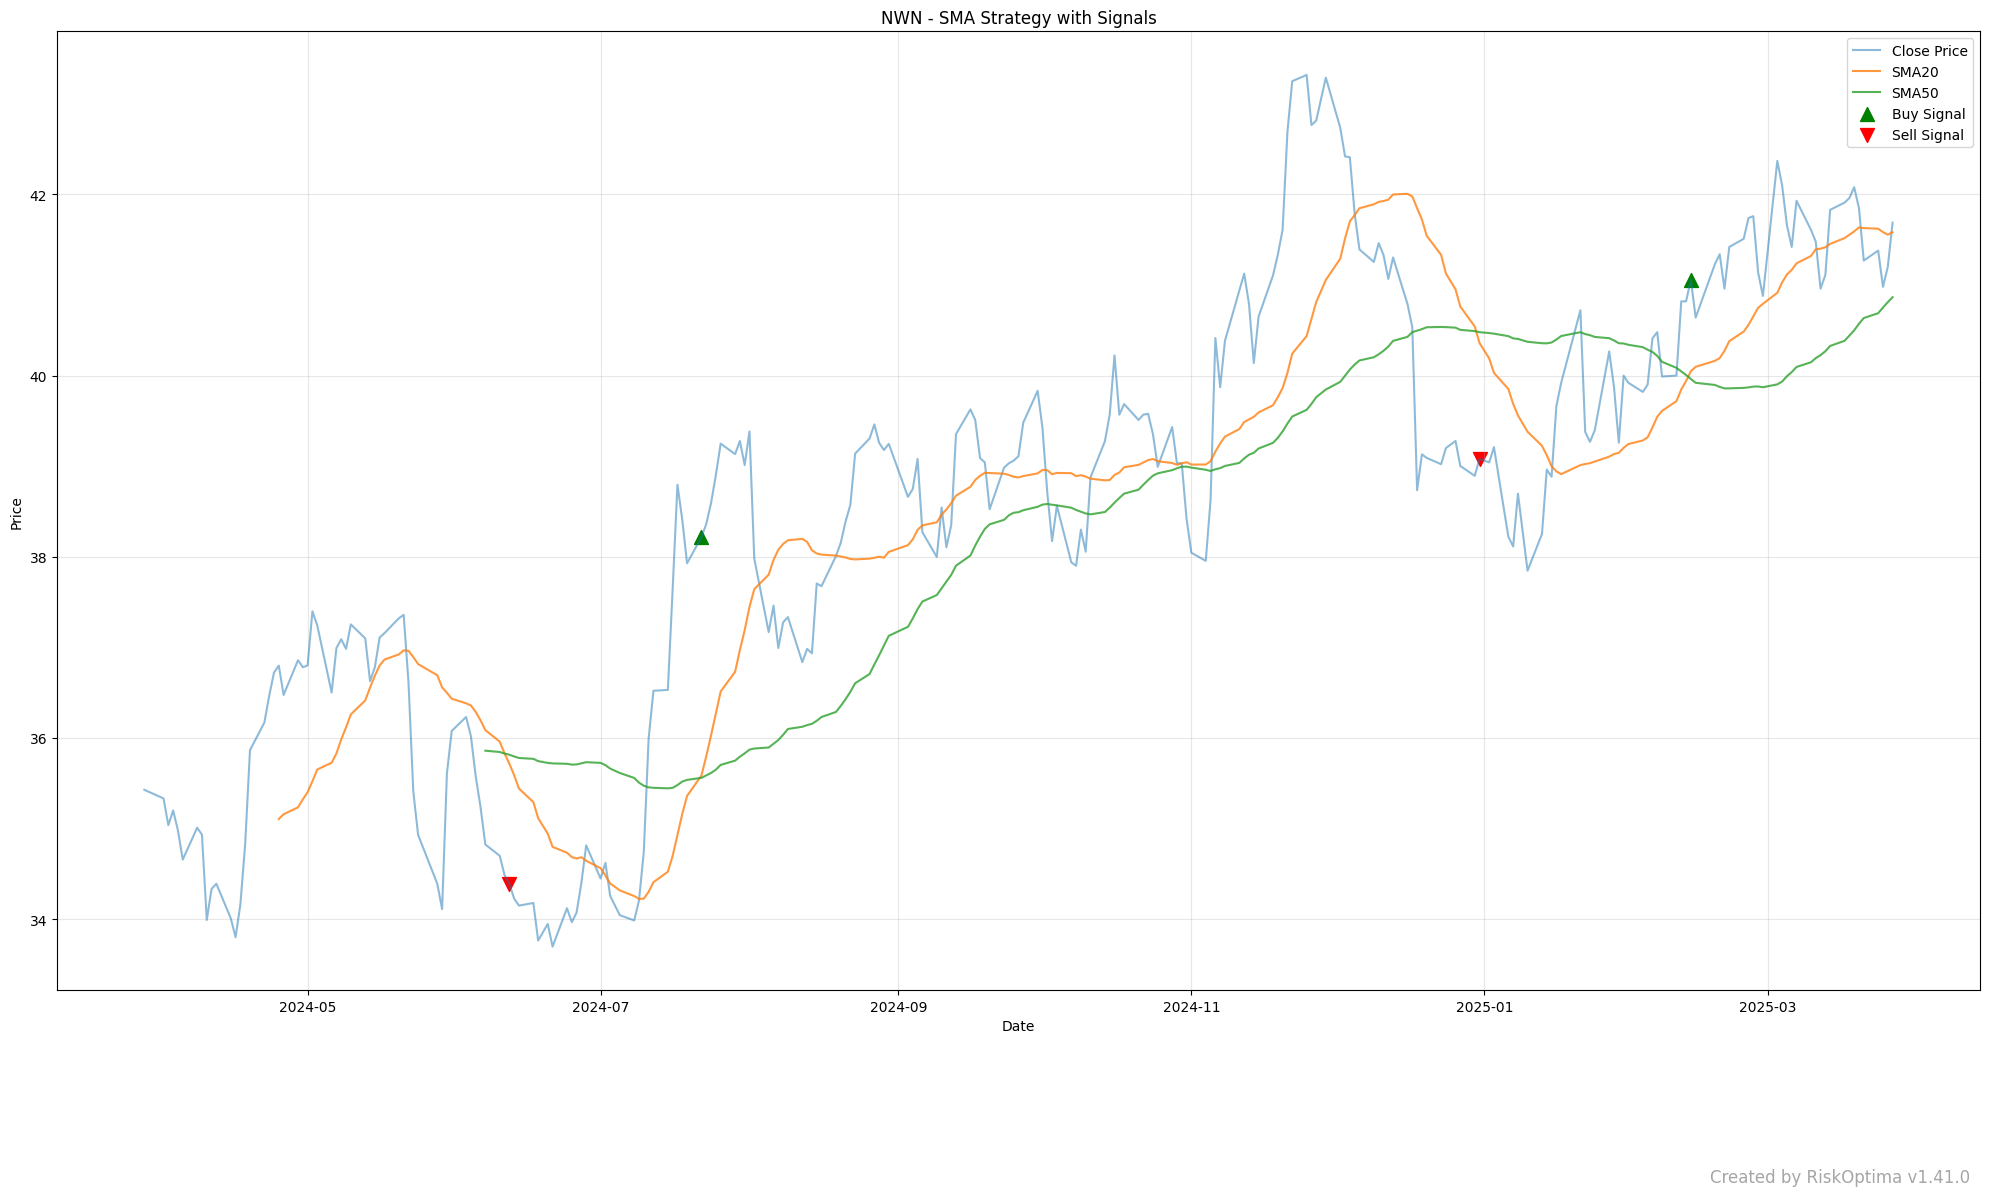

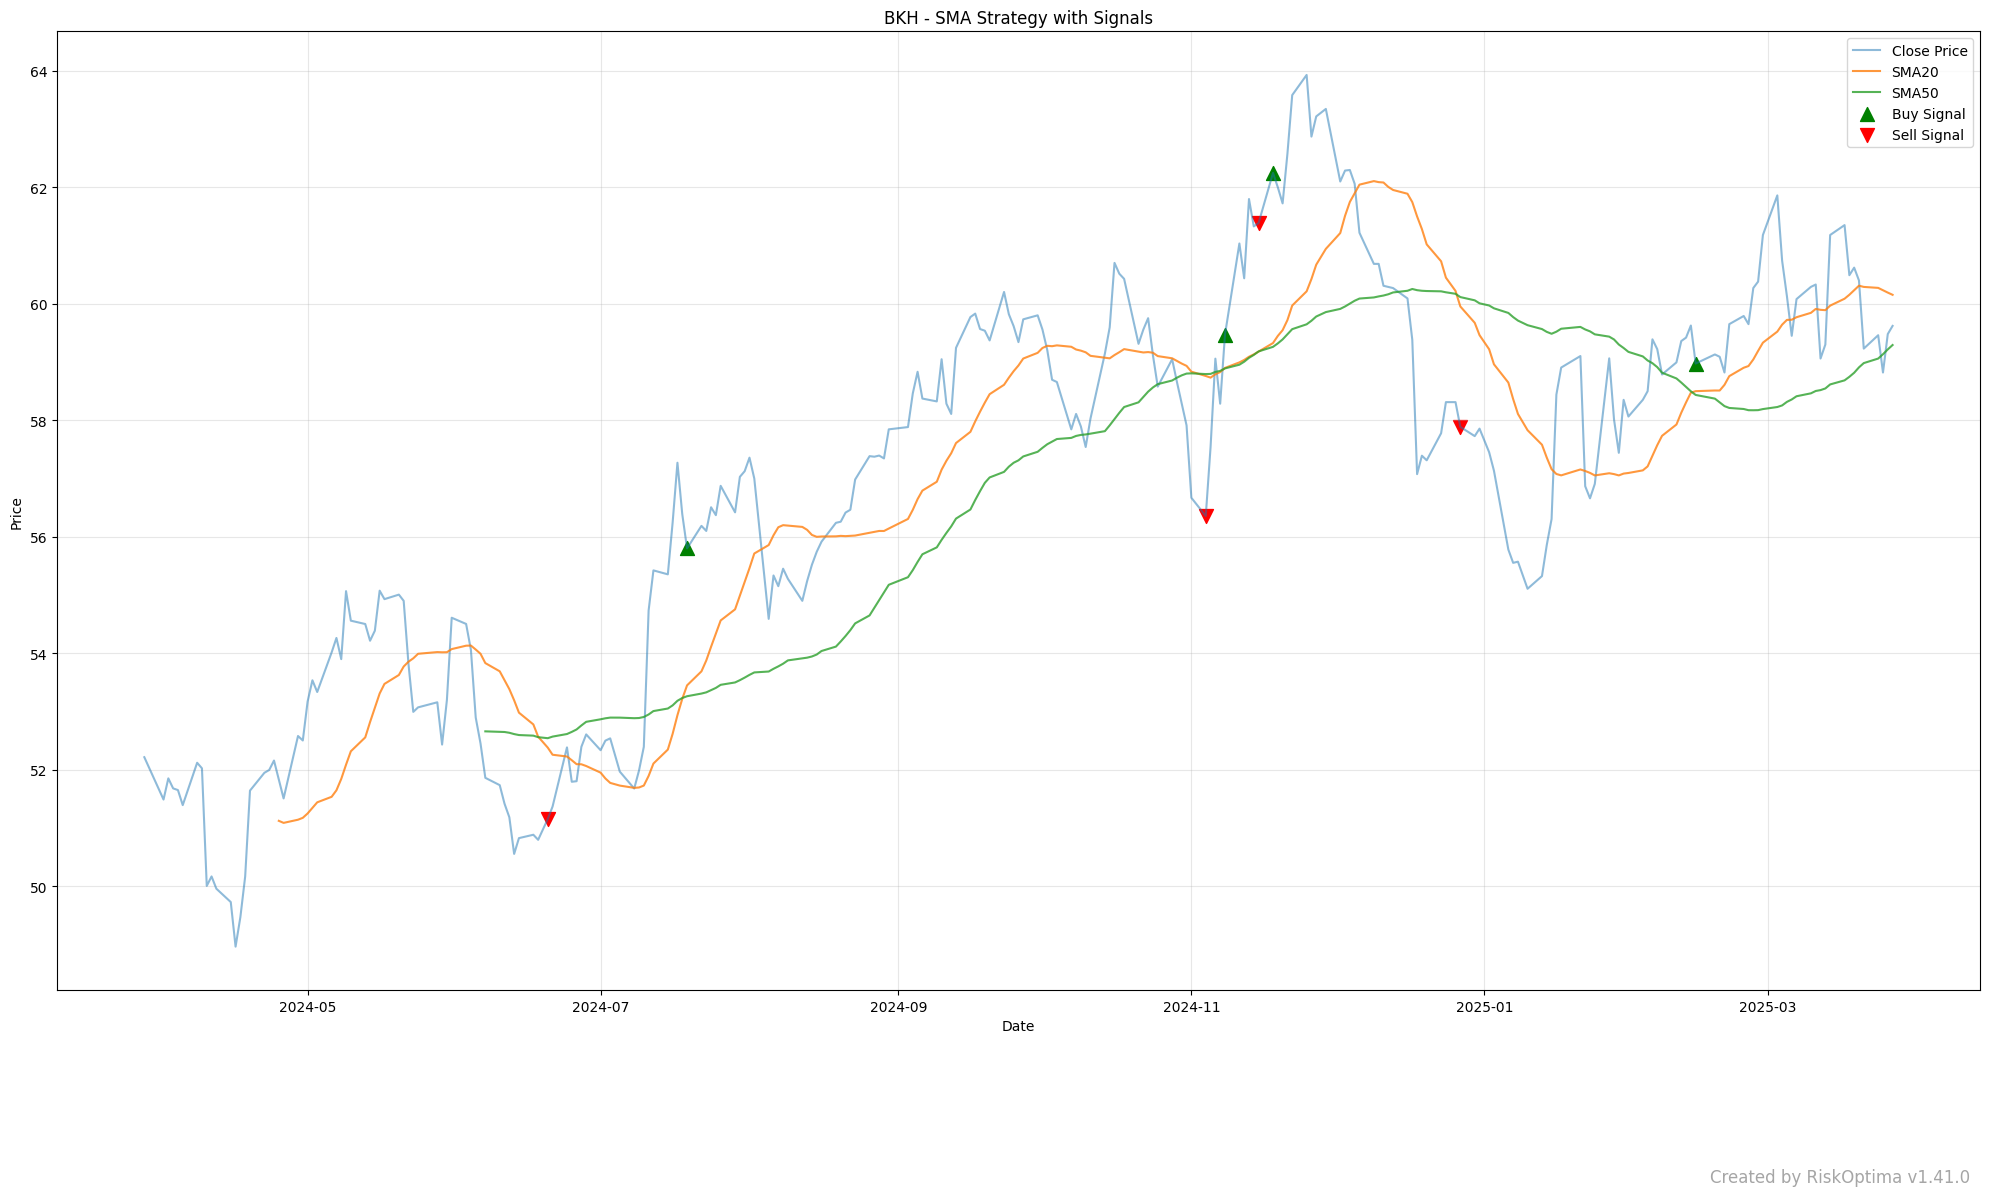

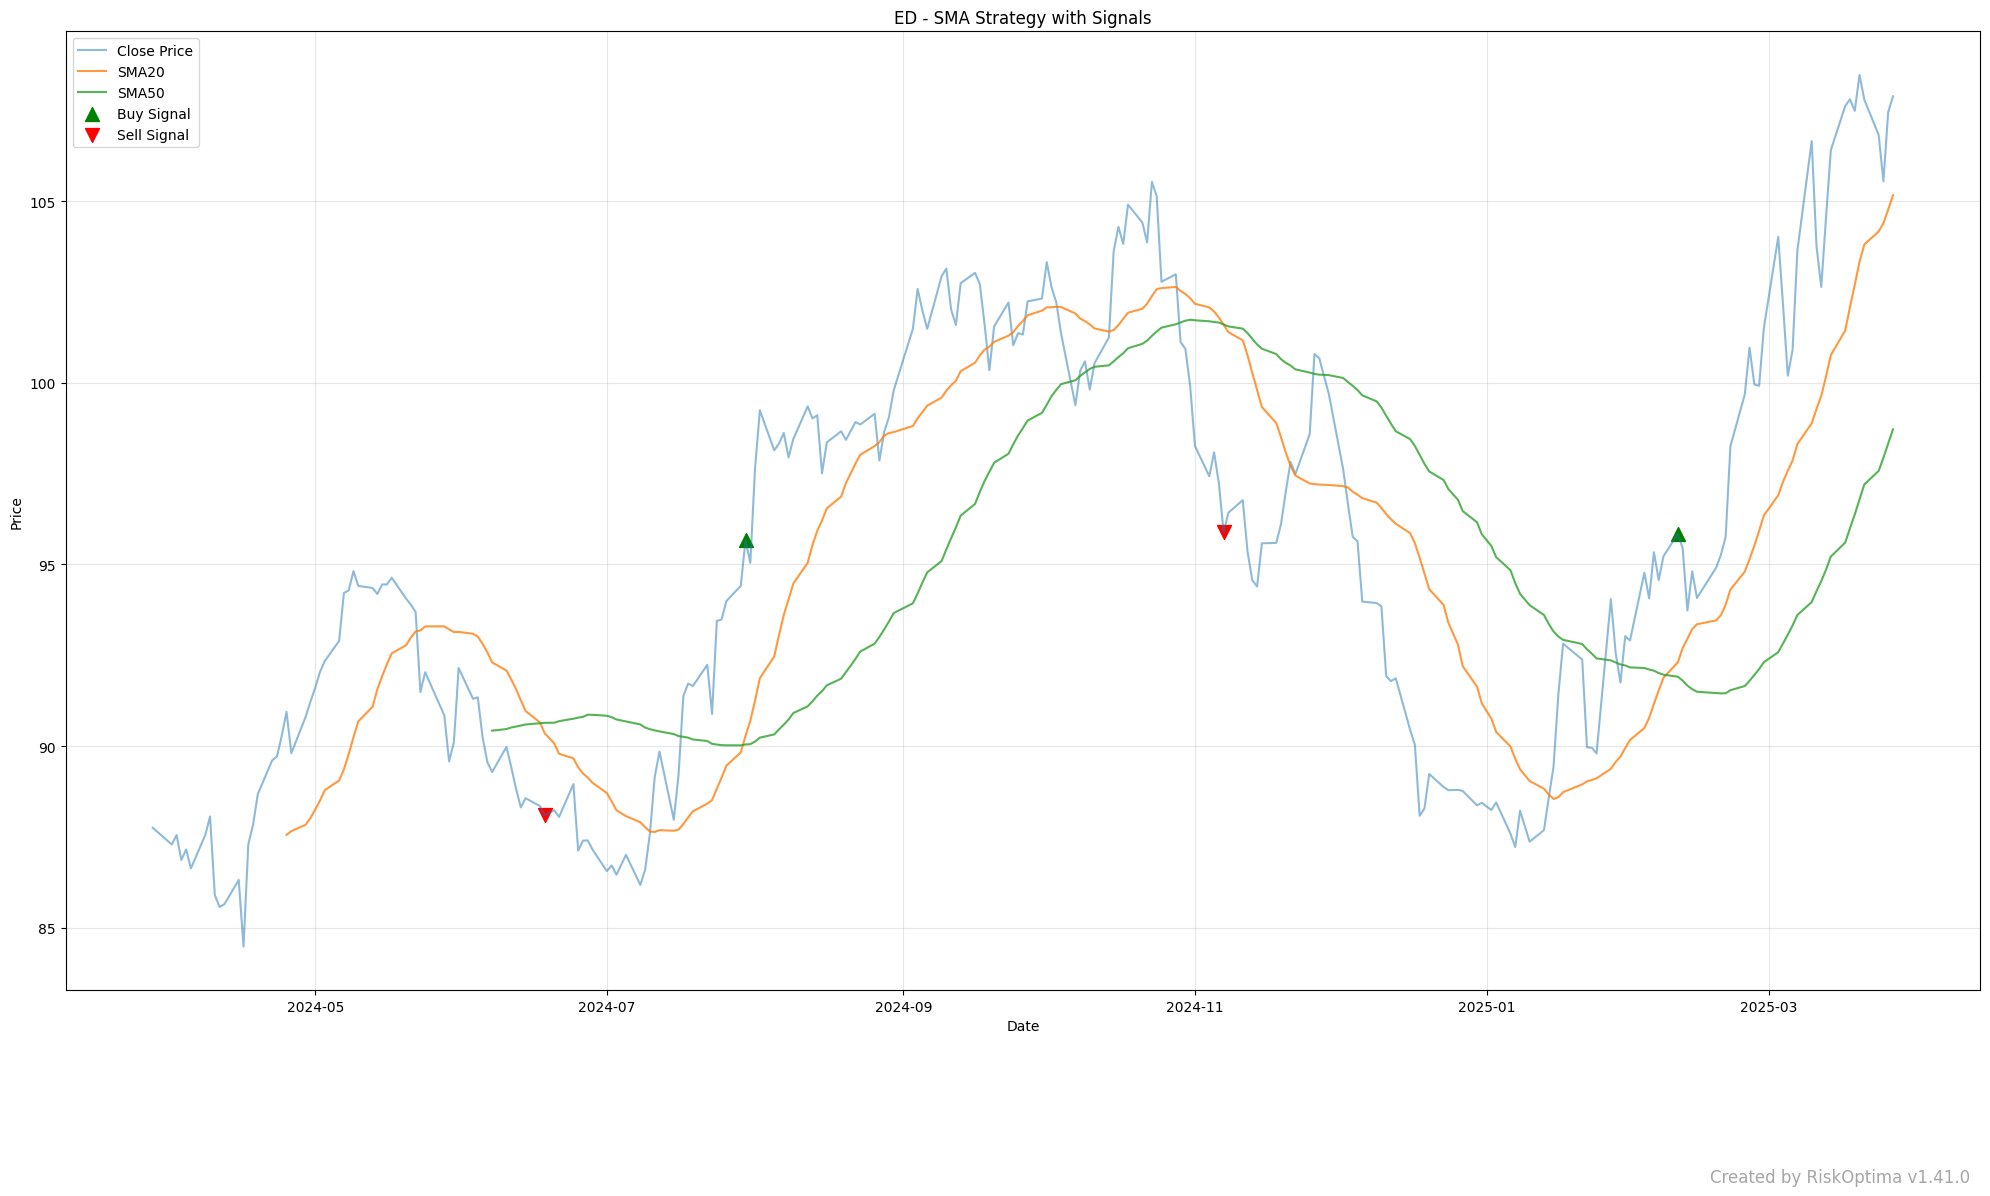

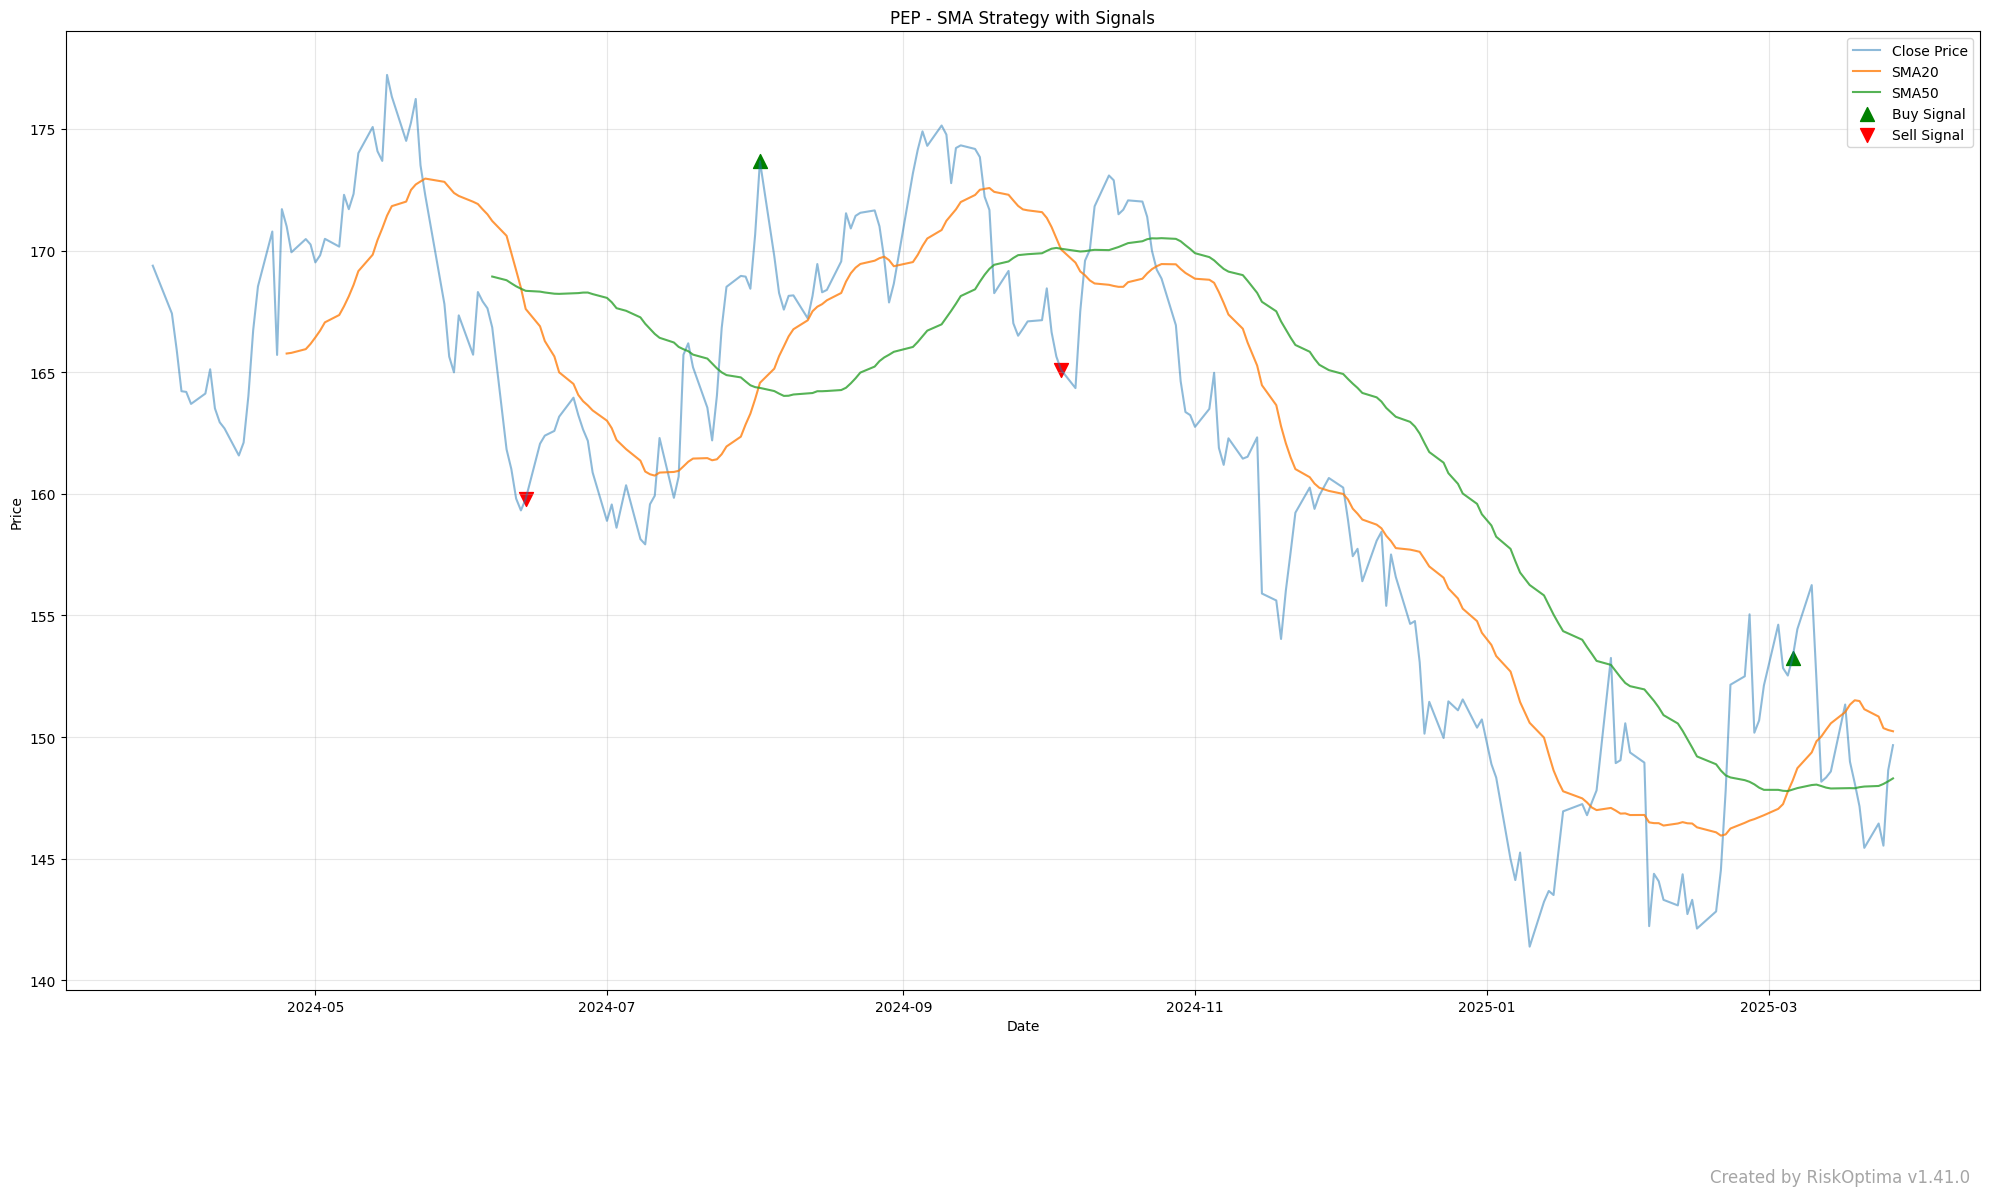

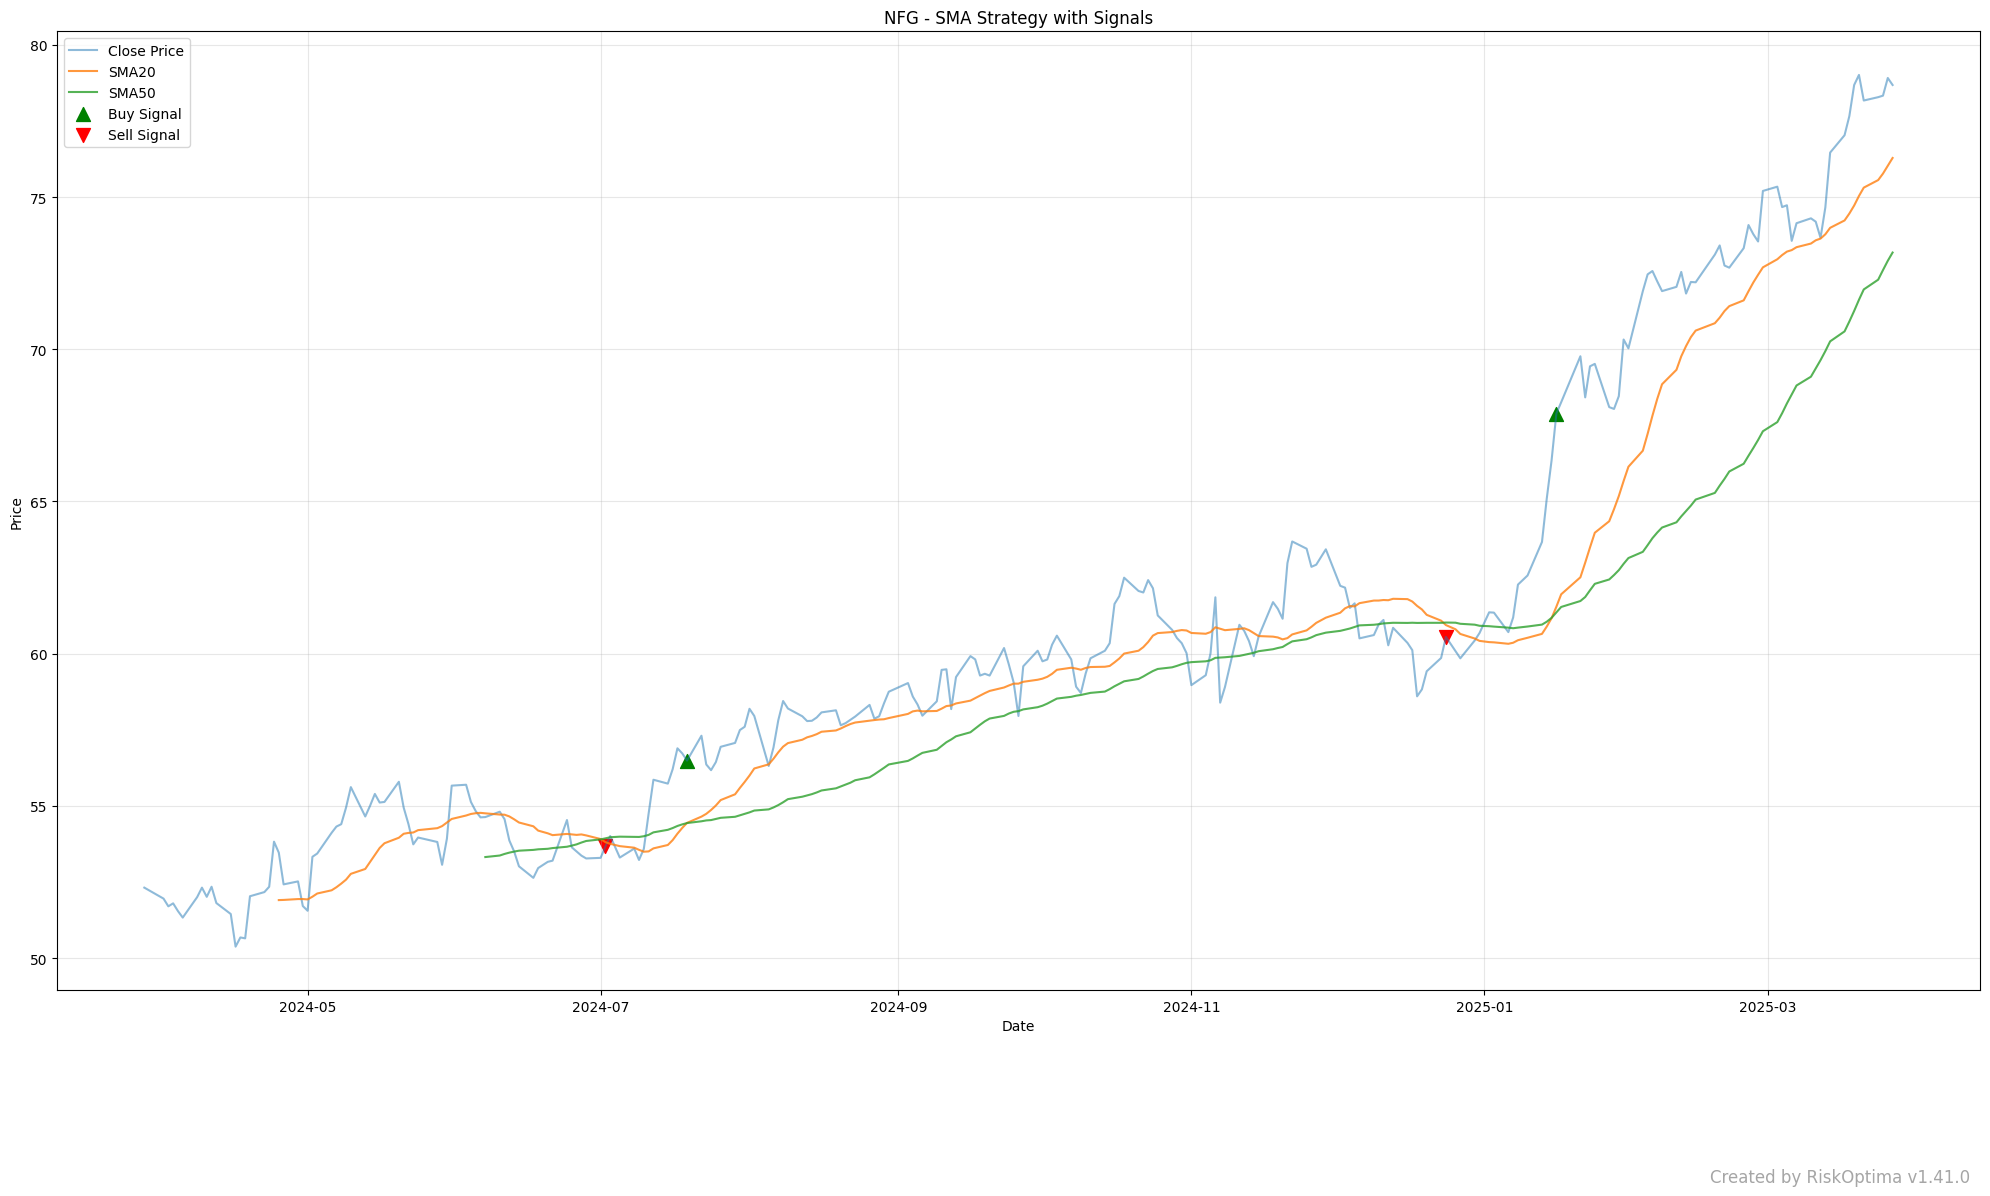

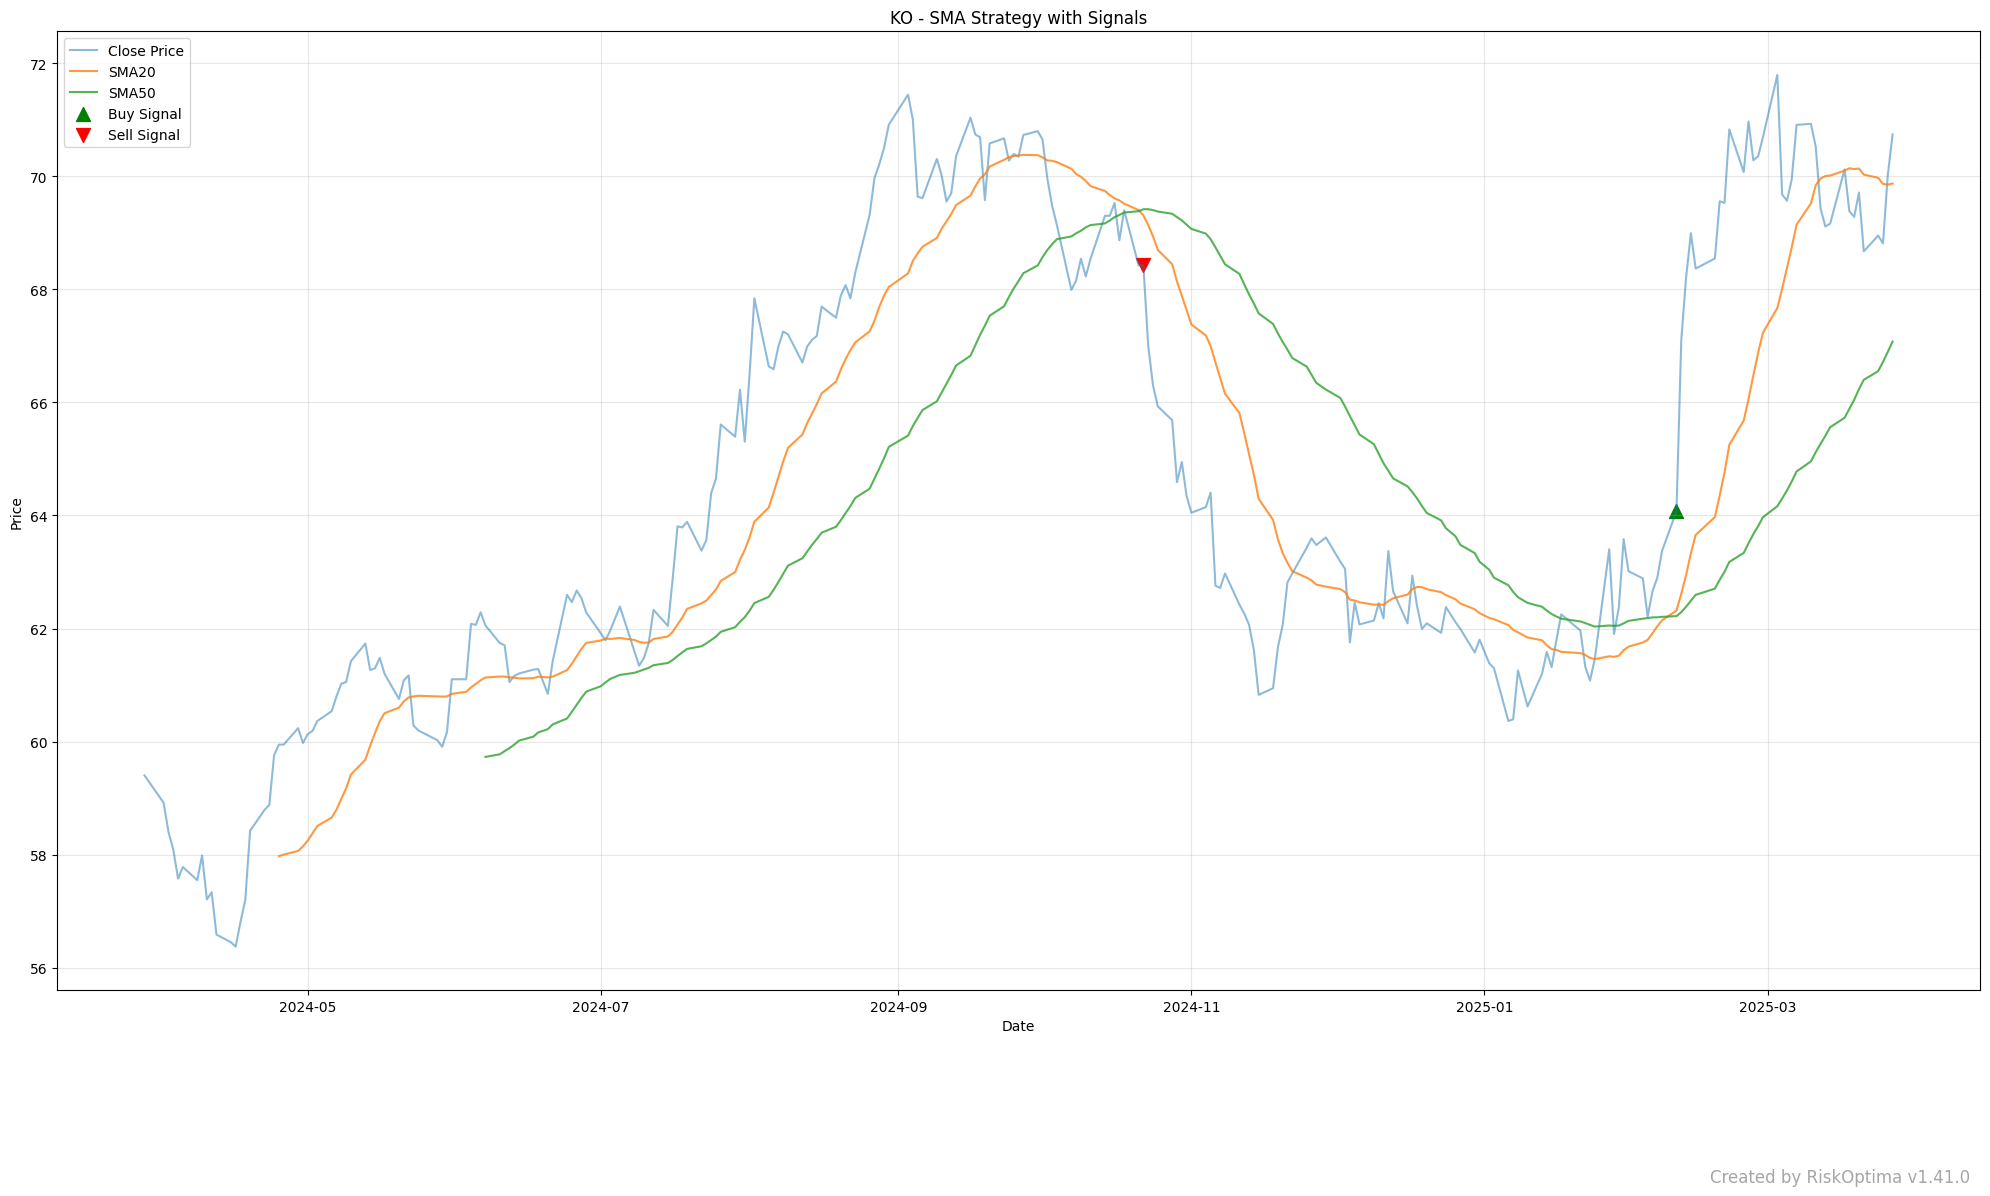

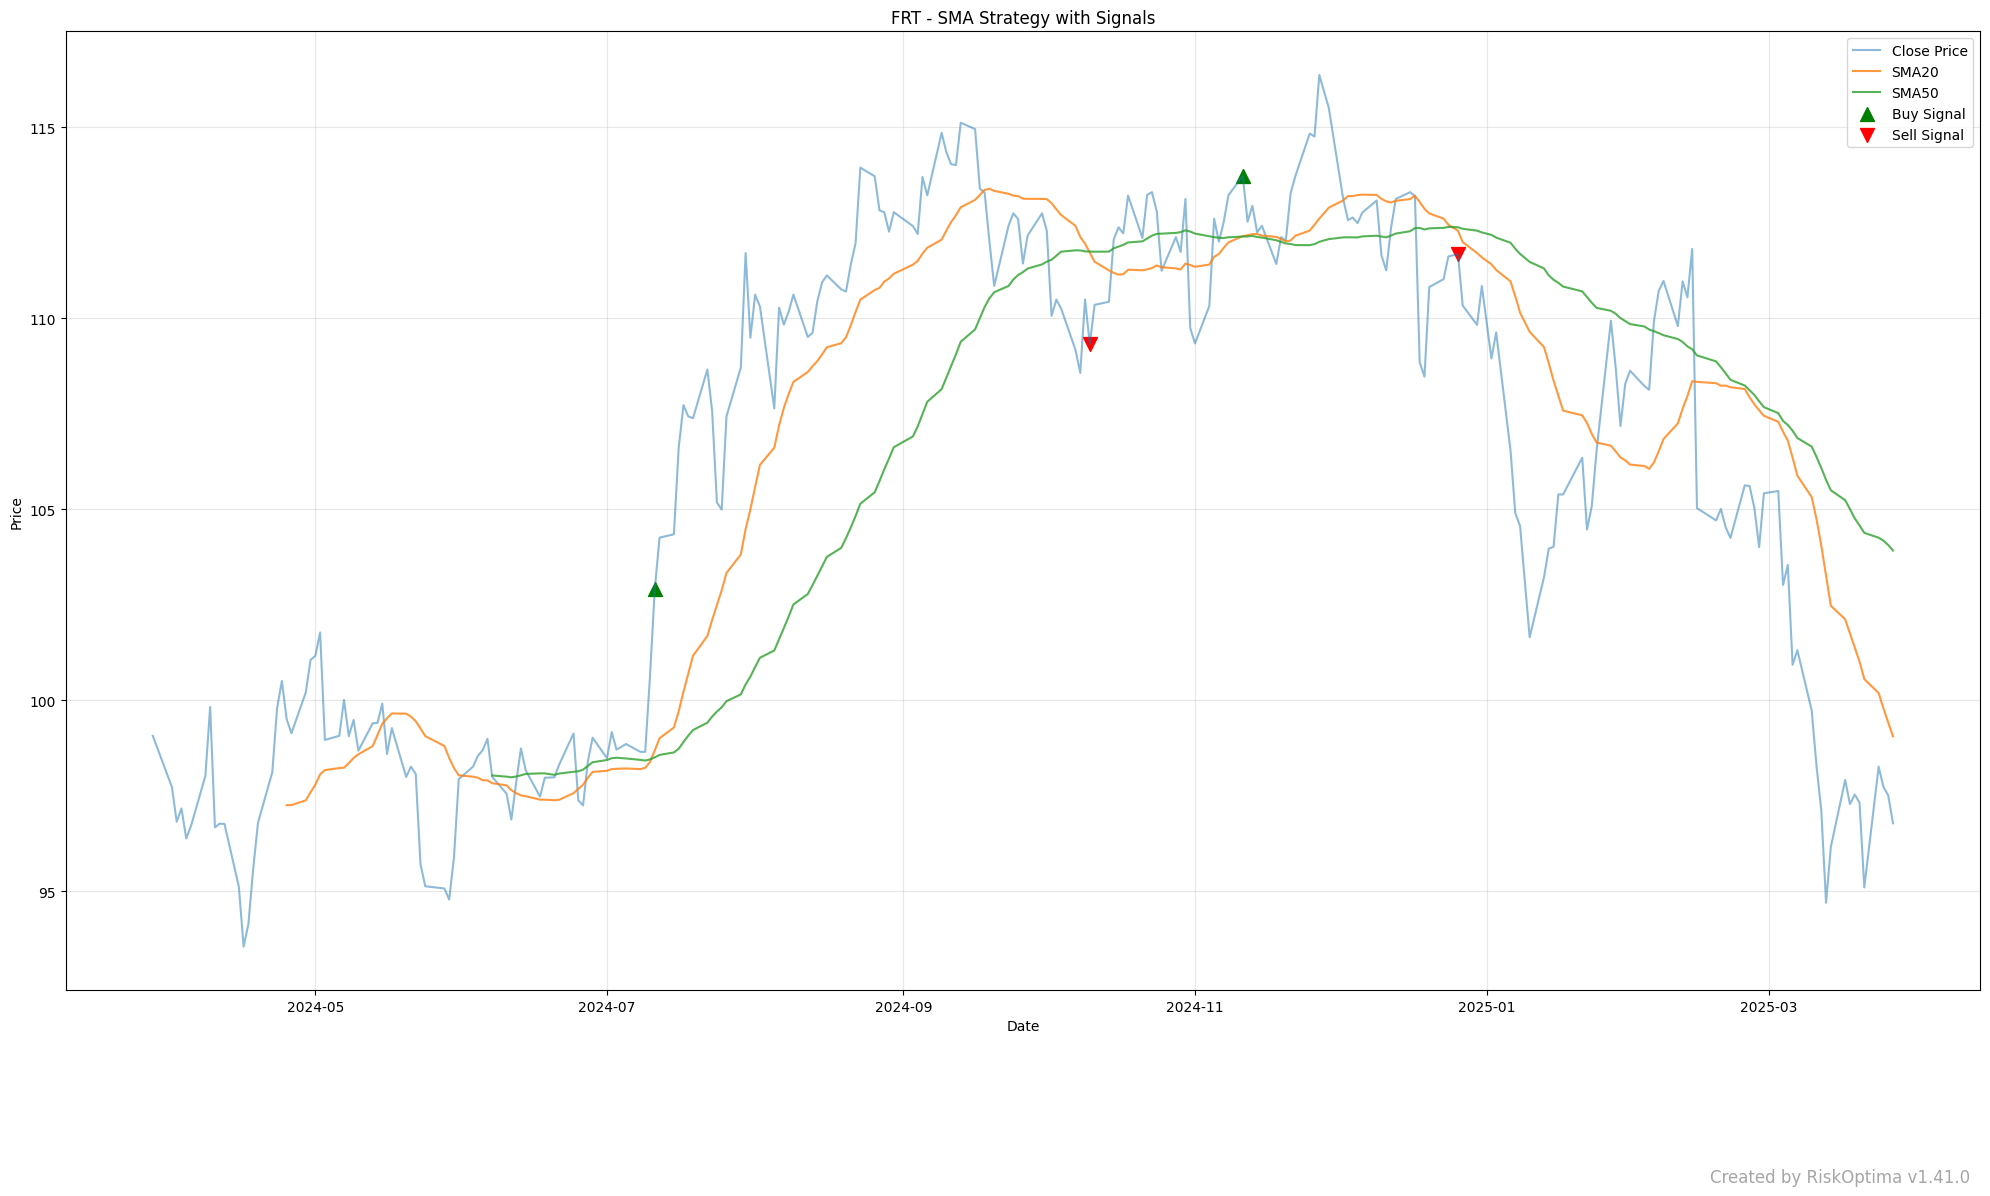

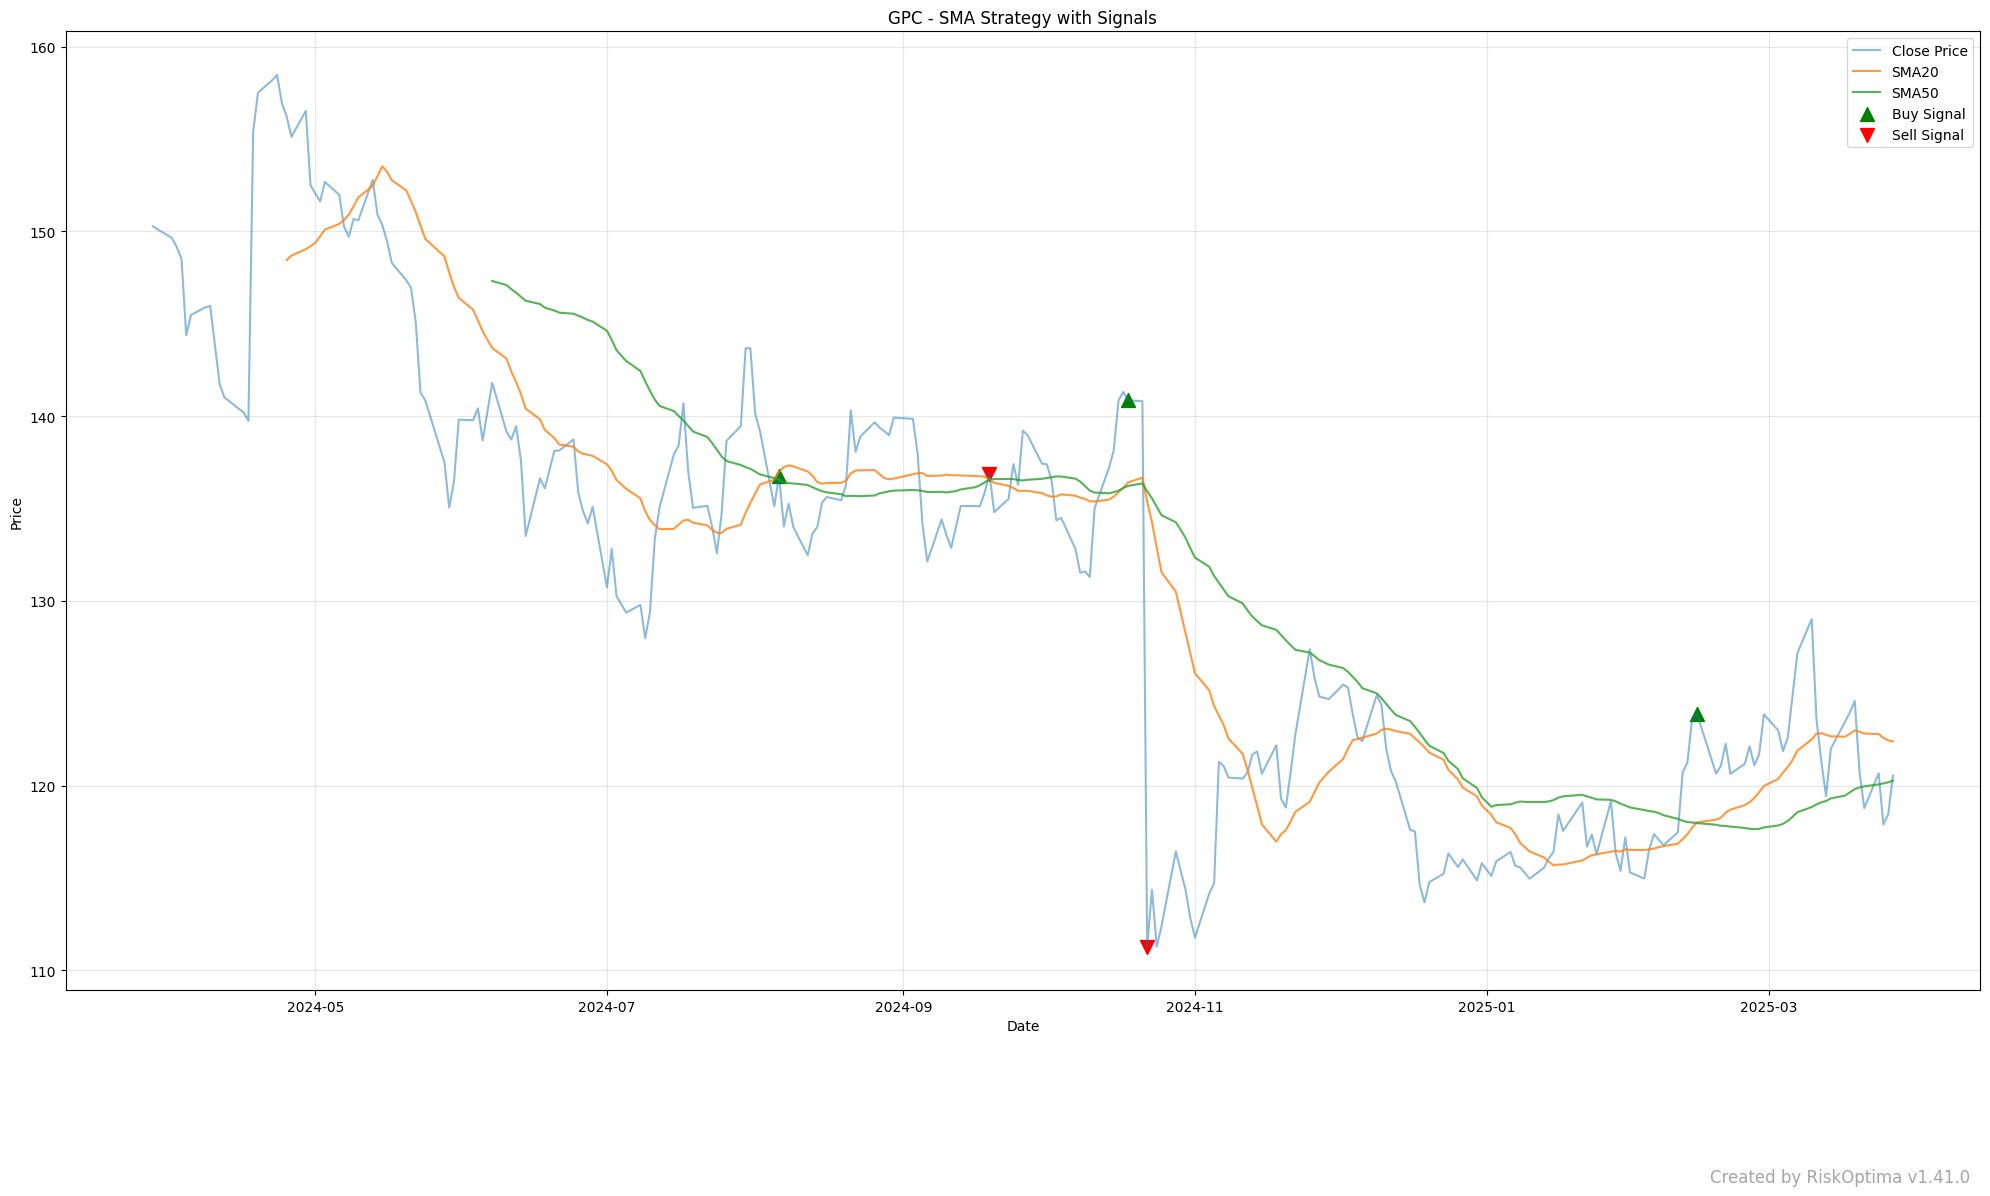

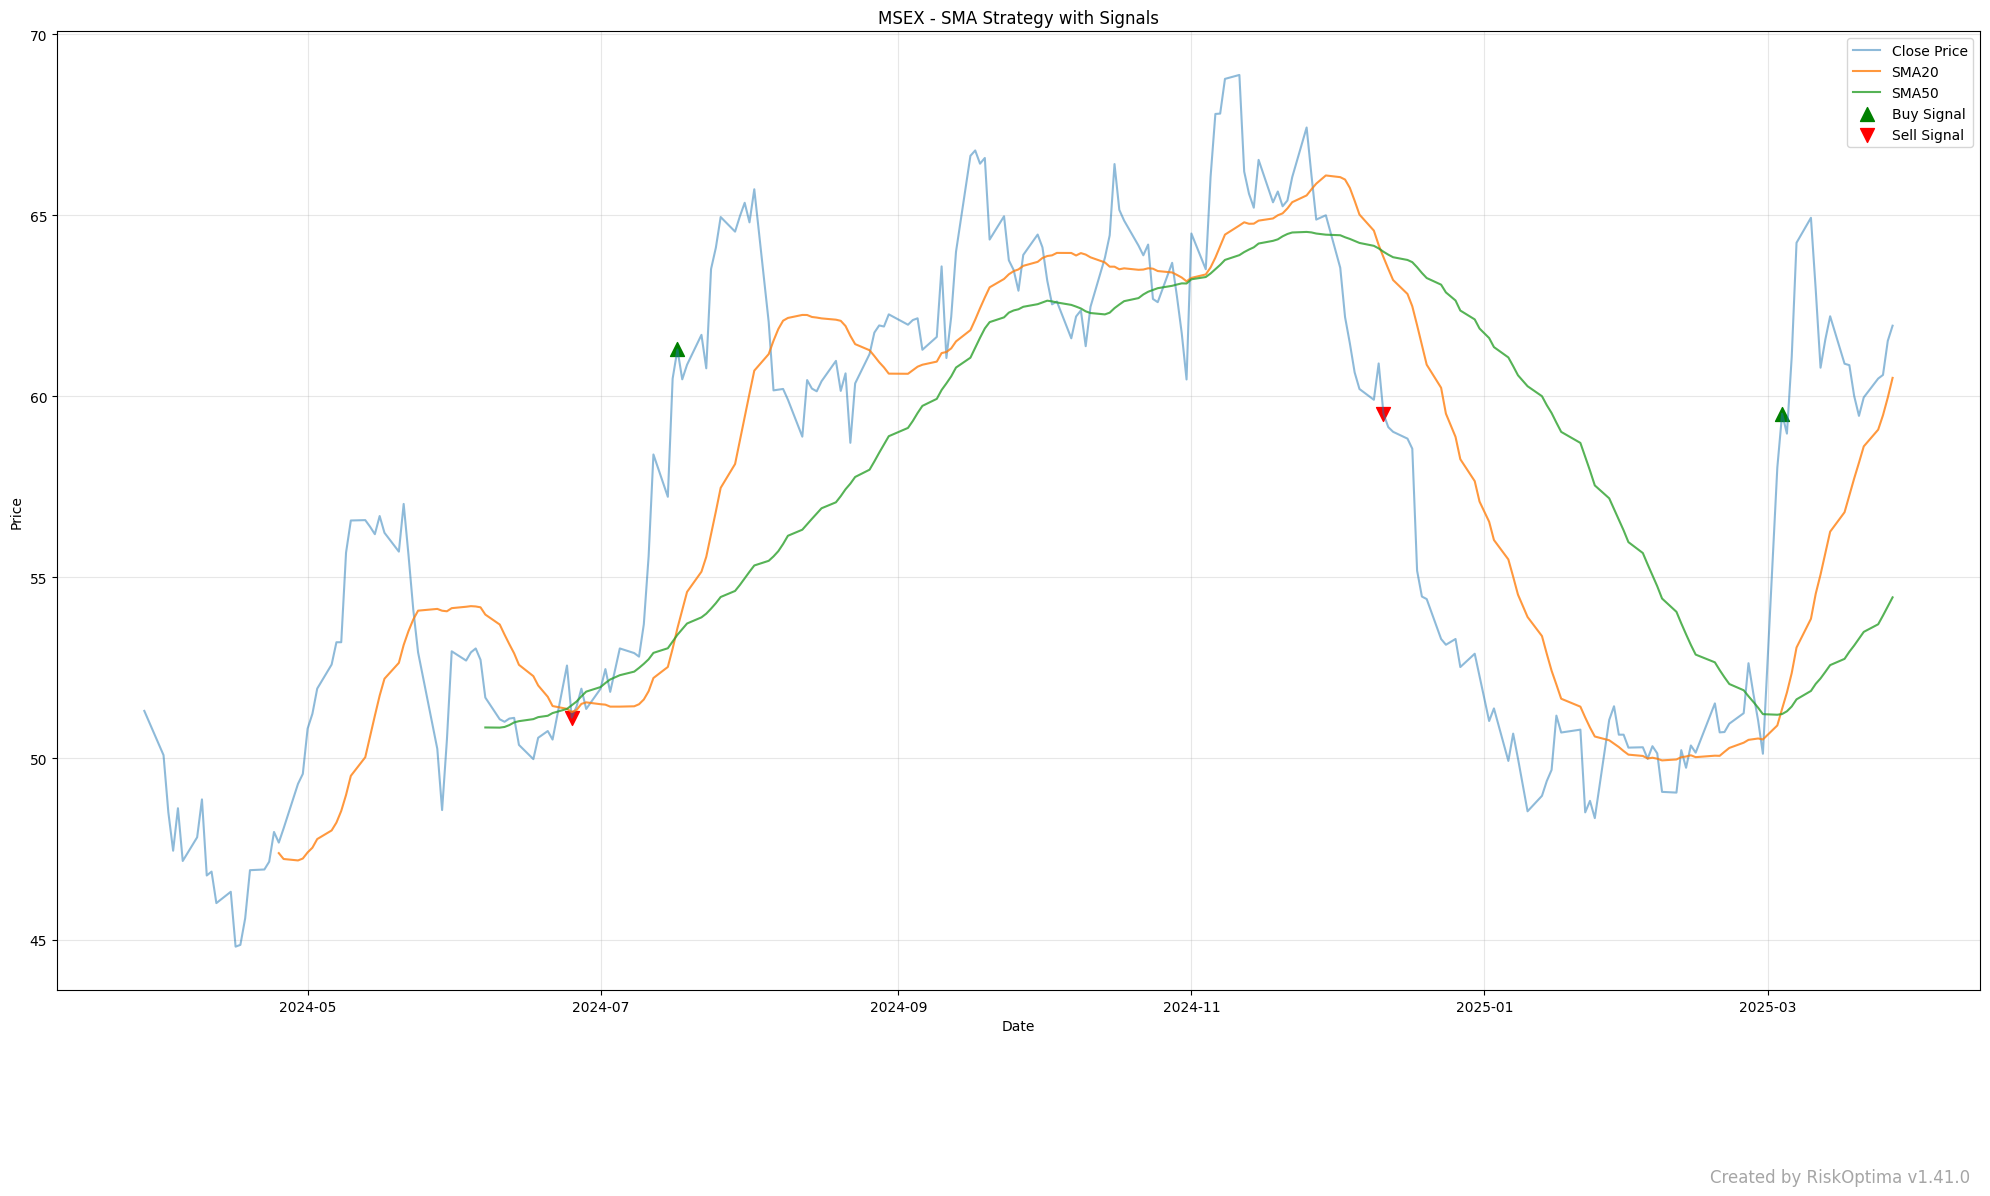

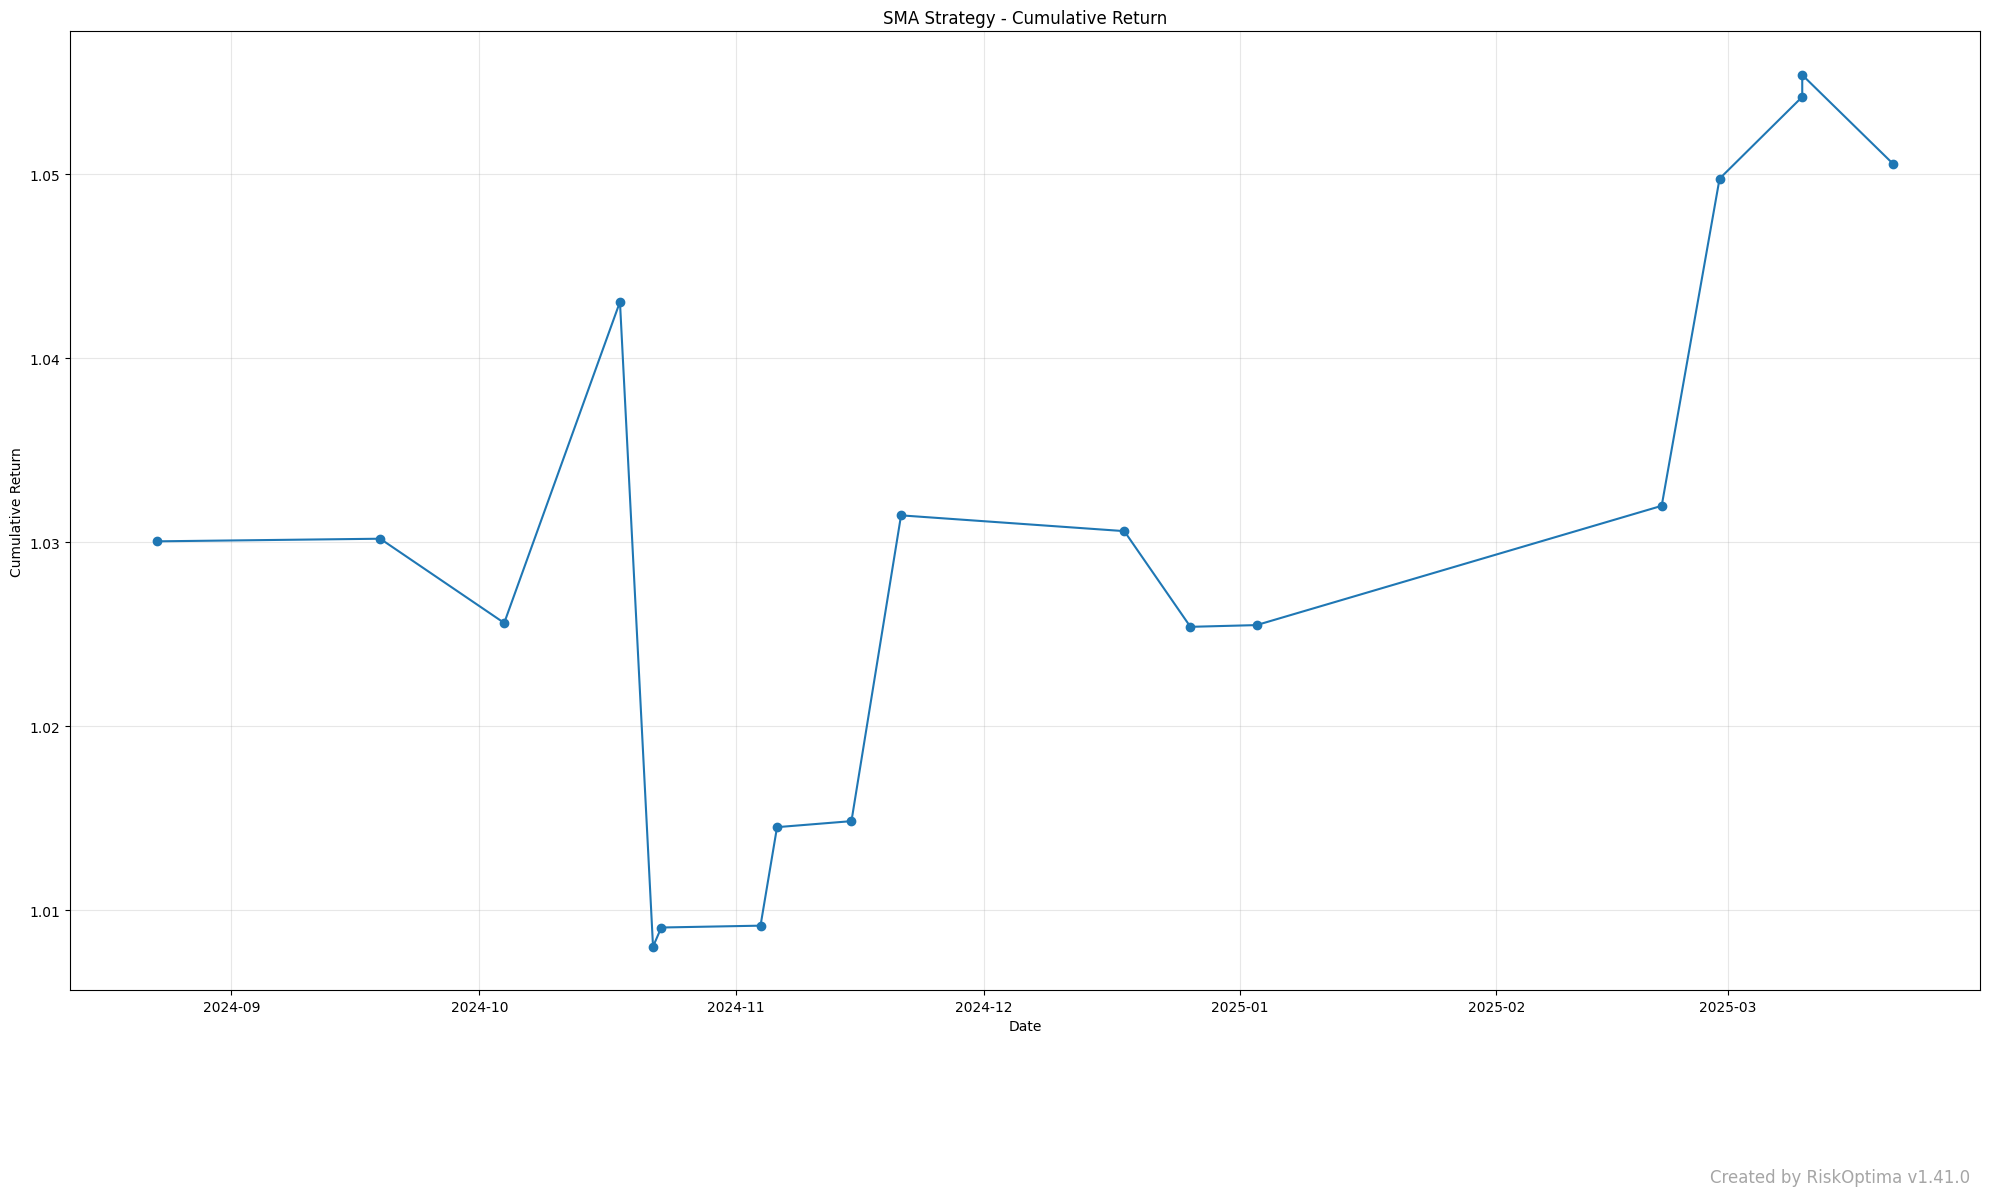

In [61]:
stop_loss=0.05
take_profit=0.10

portfolio_trades = run_strategy_on_portfolio(
            asset_table, start=ANALYSIS_START_DATE, end=ANALYSIS_END_DATE,
            stop_loss=stop_loss, take_profit=take_profit
        )
   
        # If only one ticker, also show price chart with signals
if len(asset_table) == 1:
    ticker = asset_table.iloc[0]['Asset']
    df = yf.download(ticker, start=ANALYSIS_START_DATE, end=ANALYSIS_END_DATE, progress=False)[['Close']]
    df['SMA20'] = df['Close'].rolling(20).mean()
    df['SMA50'] = df['Close'].rolling(50).mean()
    df['Signal'] = 0
    df.loc[df.index[50]:, 'Signal'] = (
        (df['SMA20'][50:] > df['SMA50'][50:]) & 
        (df['SMA20'].shift(1)[50:] <= df['SMA50'].shift(1)[50:])
    ).astype(int) - (
        (df['SMA20'][50:] < df['SMA50'][50:]) & 
        (df['SMA20'].shift(1)[50:] >= df['SMA50'].shift(1)[50:])
    ).astype(int)

    plot_sma_strategy_trades(df, ticker)

else:
    for ticker in asset_table['Asset']:
        df = yf.download(ticker, start=ANALYSIS_START_DATE, end=ANALYSIS_END_DATE, progress=False)[['Close']]
        df['SMA20'] = df['Close'].rolling(20).mean()
        df['SMA50'] = df['Close'].rolling(50).mean()
        df['Signal'] = 0
        df.loc[df.index[50]:, 'Signal'] = (
            (df['SMA20'][50:] > df['SMA50'][50:]) & 
            (df['SMA20'].shift(1)[50:] <= df['SMA50'].shift(1)[50:])
        ).astype(int) - (
            (df['SMA20'][50:] < df['SMA50'][50:]) & 
            (df['SMA20'].shift(1)[50:] >= df['SMA50'].shift(1)[50:])
        ).astype(int)
    
        plot_sma_strategy_trades(df, ticker)

# Always plot cumulative return
plot_sma_strategy_cumulative_return(portfolio_trades, title="SMA Strategy - Cumulative Return")

  Asset  Weight
0   SPY     1.0


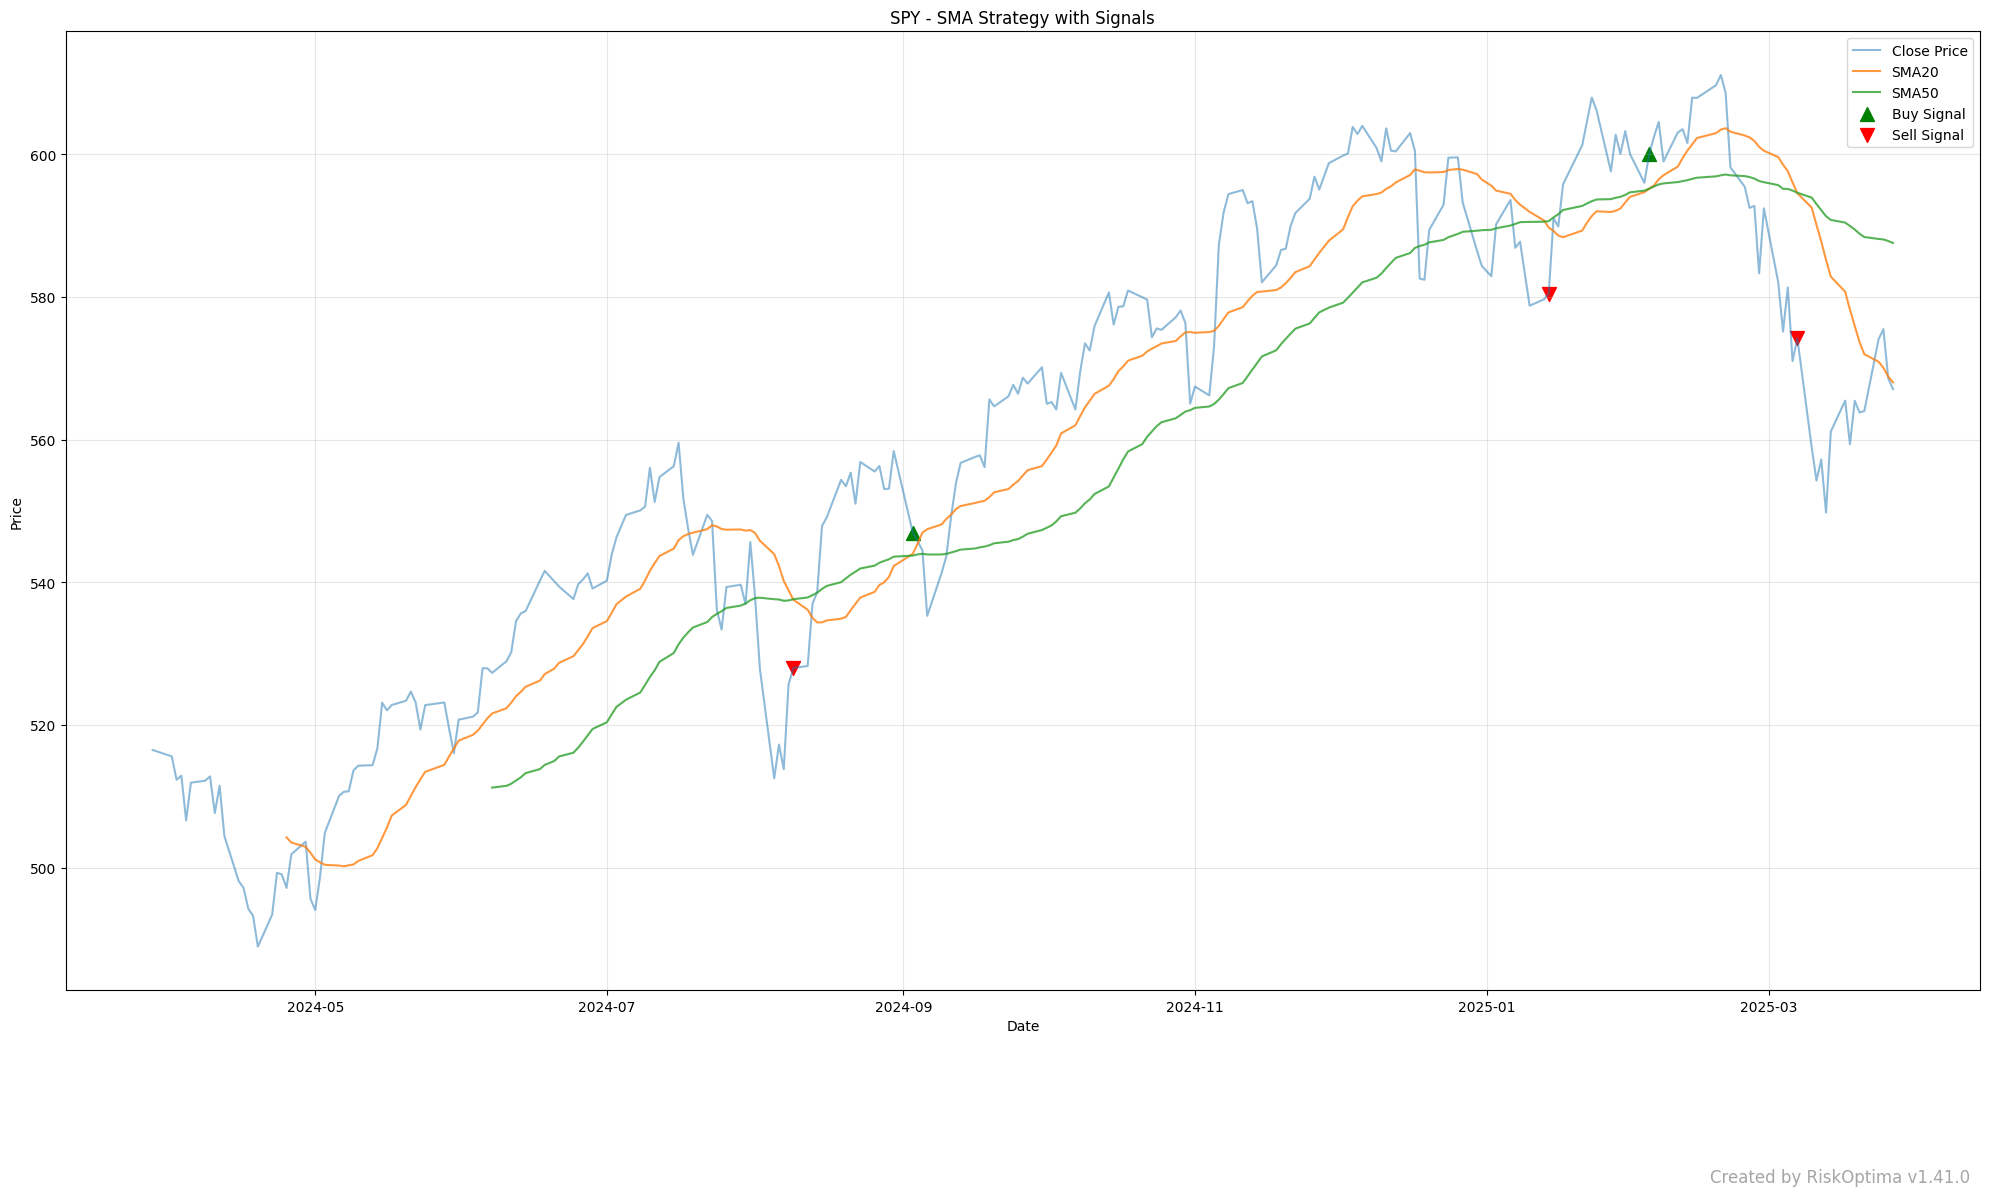

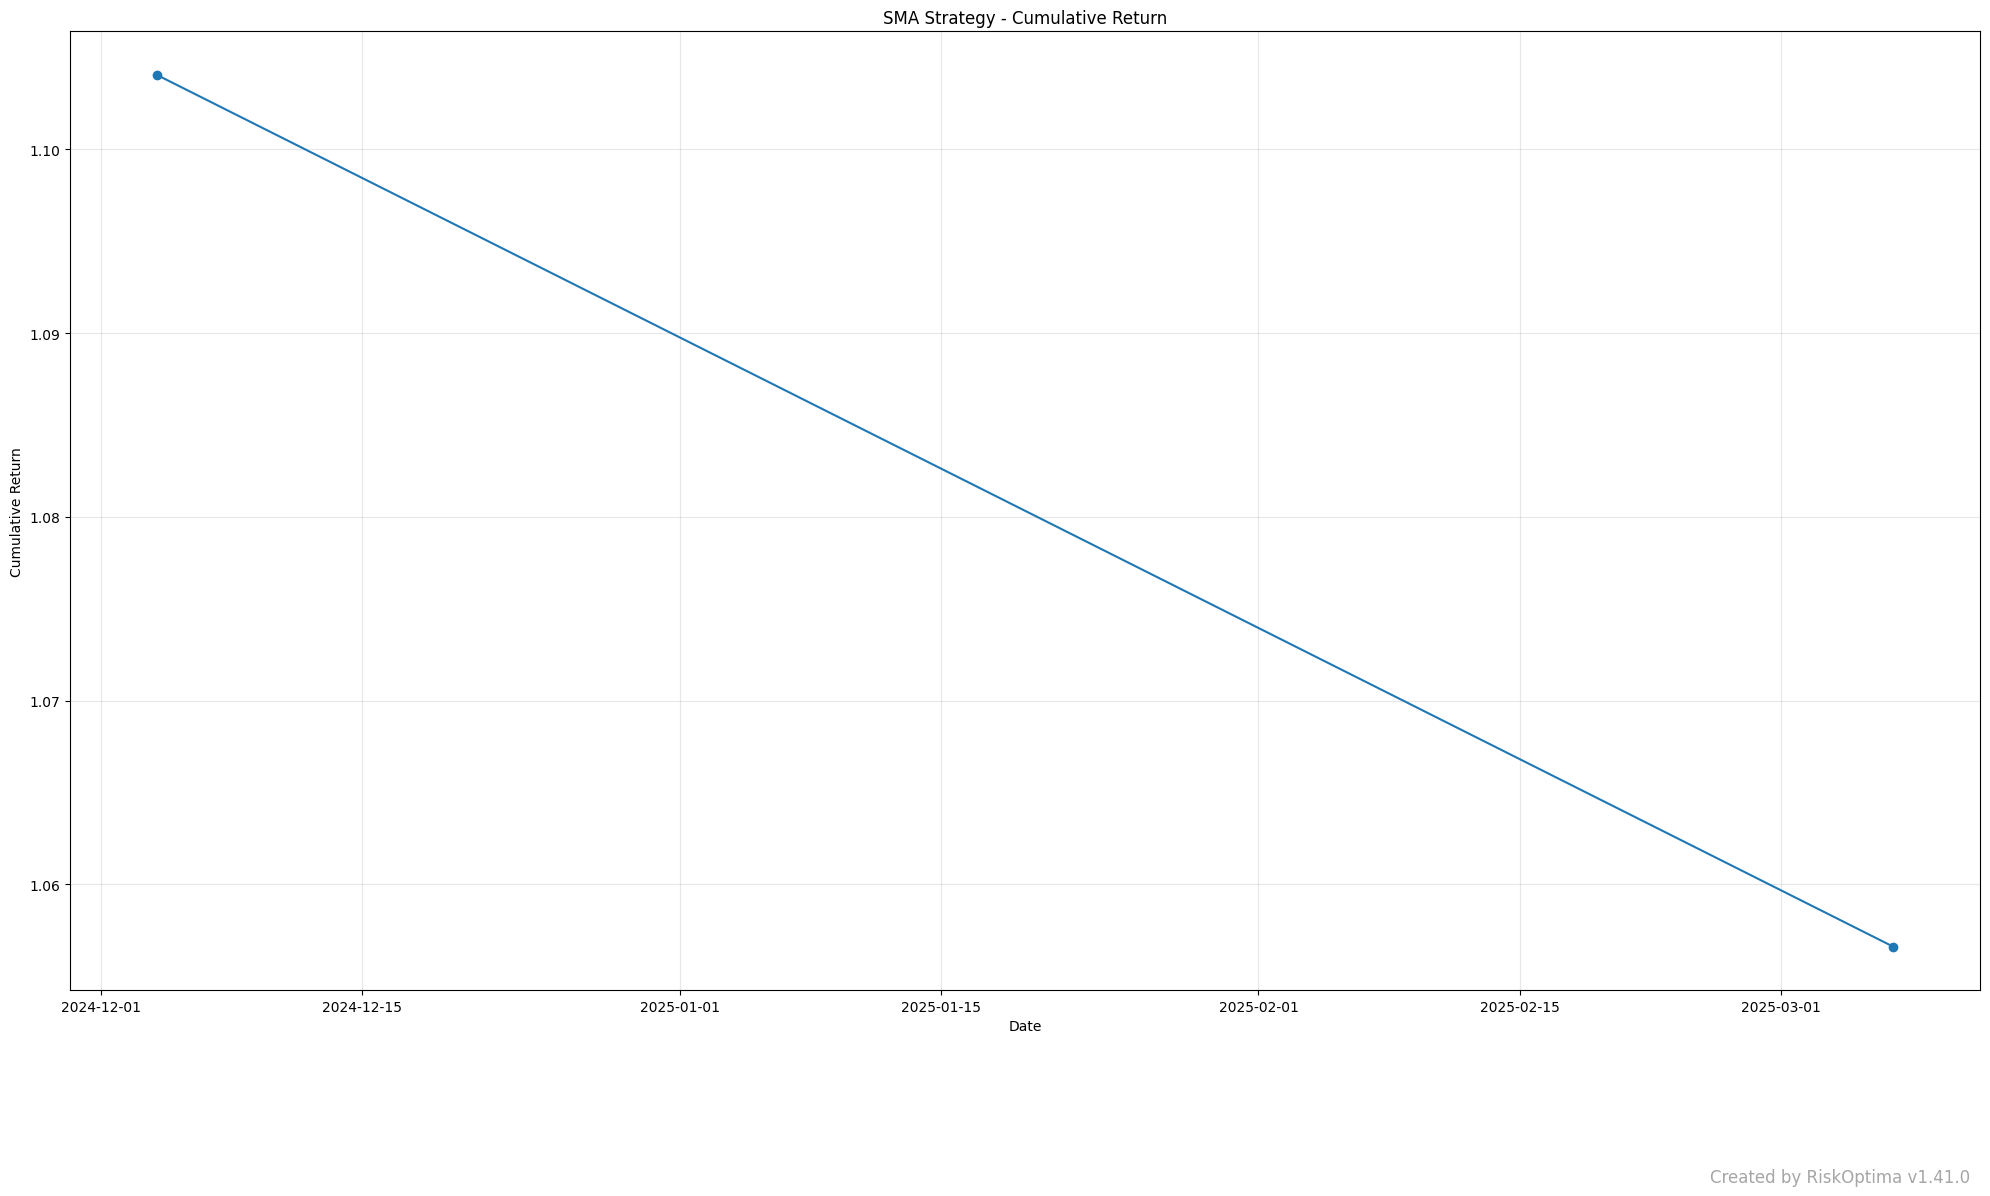

  Asset    Weight
0   SPY  0.333333
1  AAPL  0.333333
2    KO  0.333333


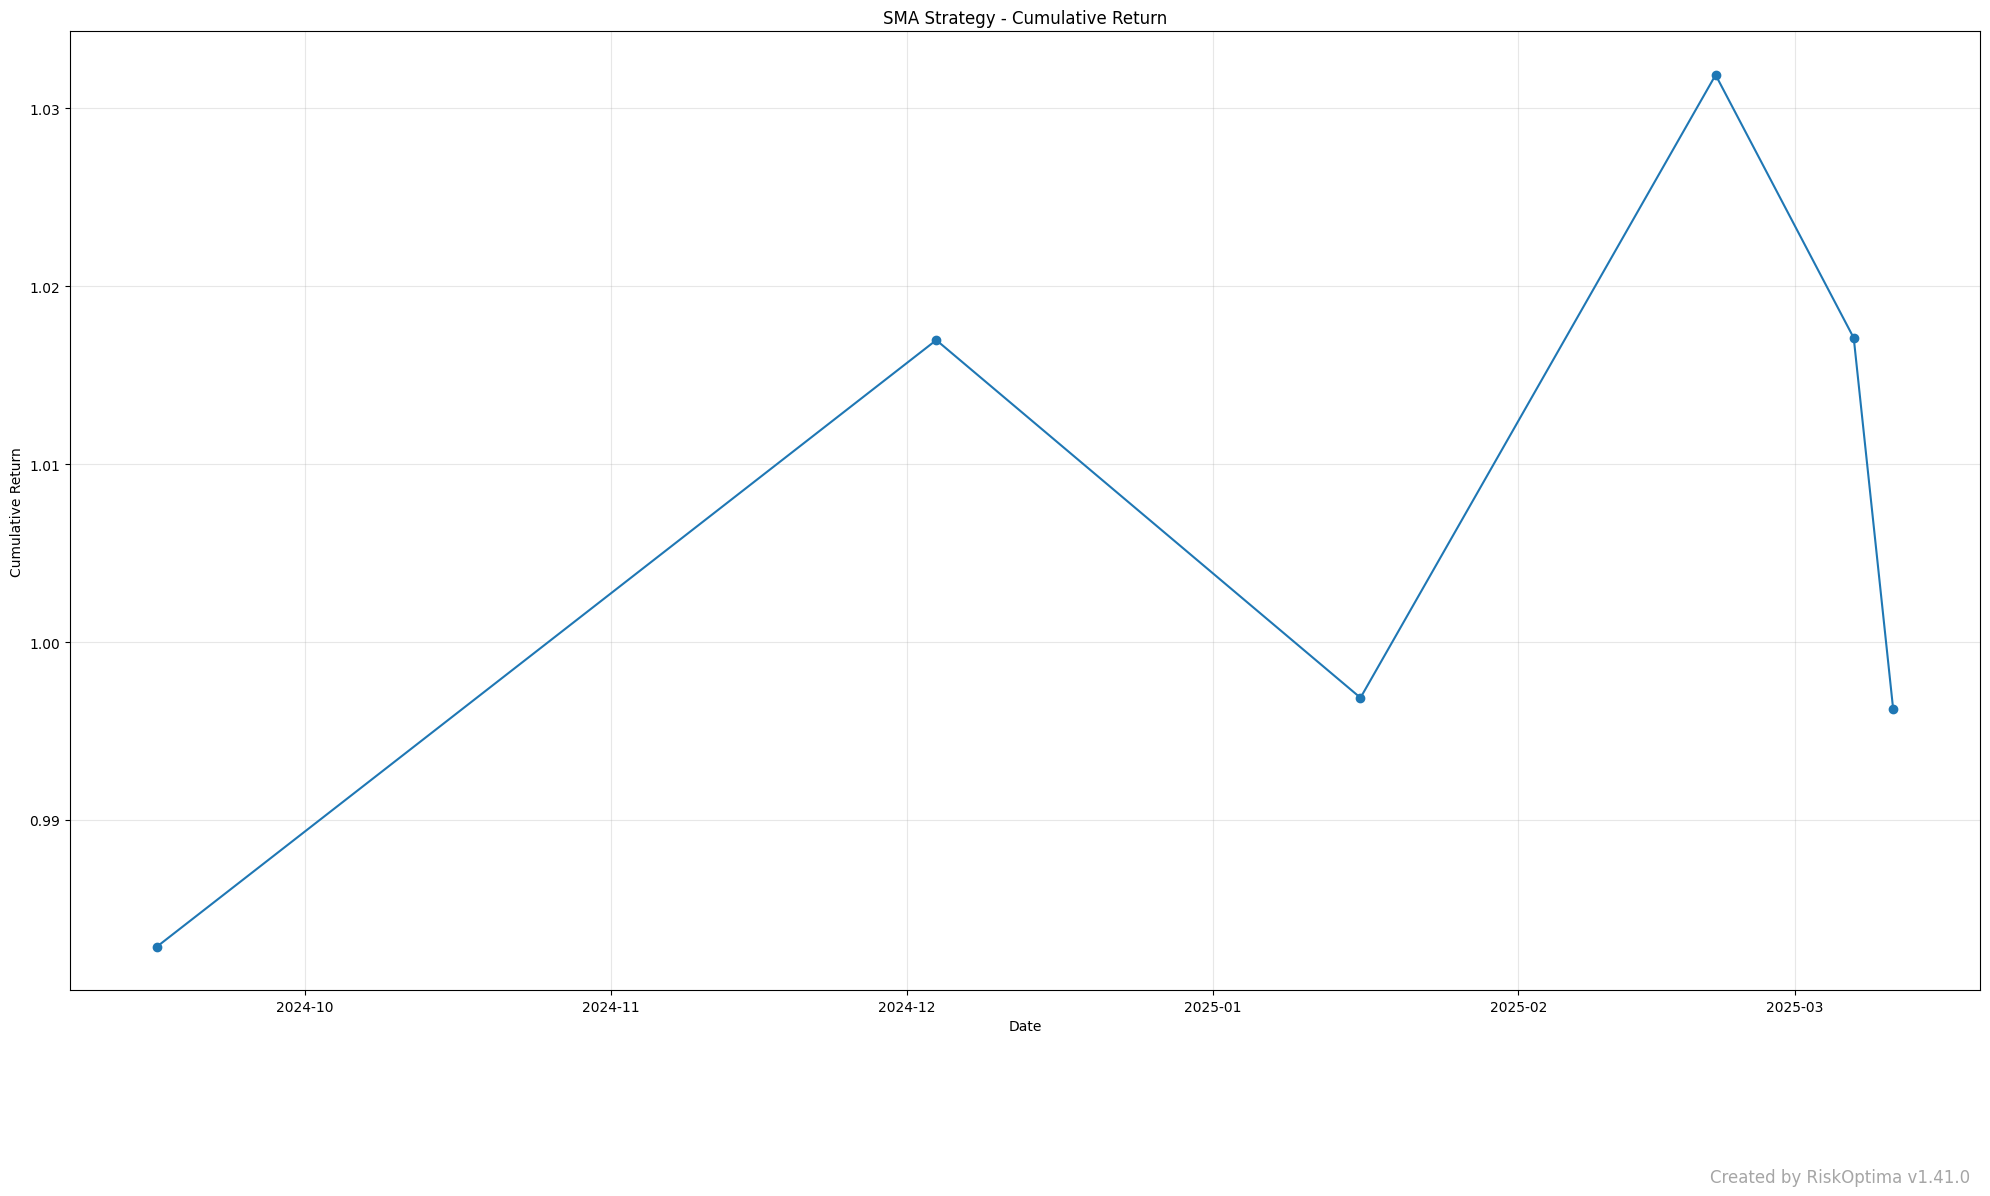

  Asset  Weight                      Label     MarketCap  Portfolio
0    MO    0.04          Altria Group Inc.  1.100000e+11     4000.0
1   NWN    0.14      Northwest Natural Gas  1.800000e+09    14000.0
2   BKH    0.01          Black Hills Corp.  4.500000e+09     1000.0
3    ED    0.01                 Con Edison  3.000000e+10     1000.0
4   PEP    0.09               PepsiCo Inc.  2.550000e+11     9000.0
5   NFG    0.16          National Fuel Gas  5.600000e+09    16000.0
6    KO    0.06          Coca-Cola Company  2.750000e+11     6000.0
7   FRT    0.28  Federal Realty Inv. Trust  9.800000e+09    28000.0
8   GPC    0.16          Genuine Parts Co.  2.530000e+10    16000.0
9  MSEX    0.05        Middlesex Water Co.  2.400000e+09     5000.0


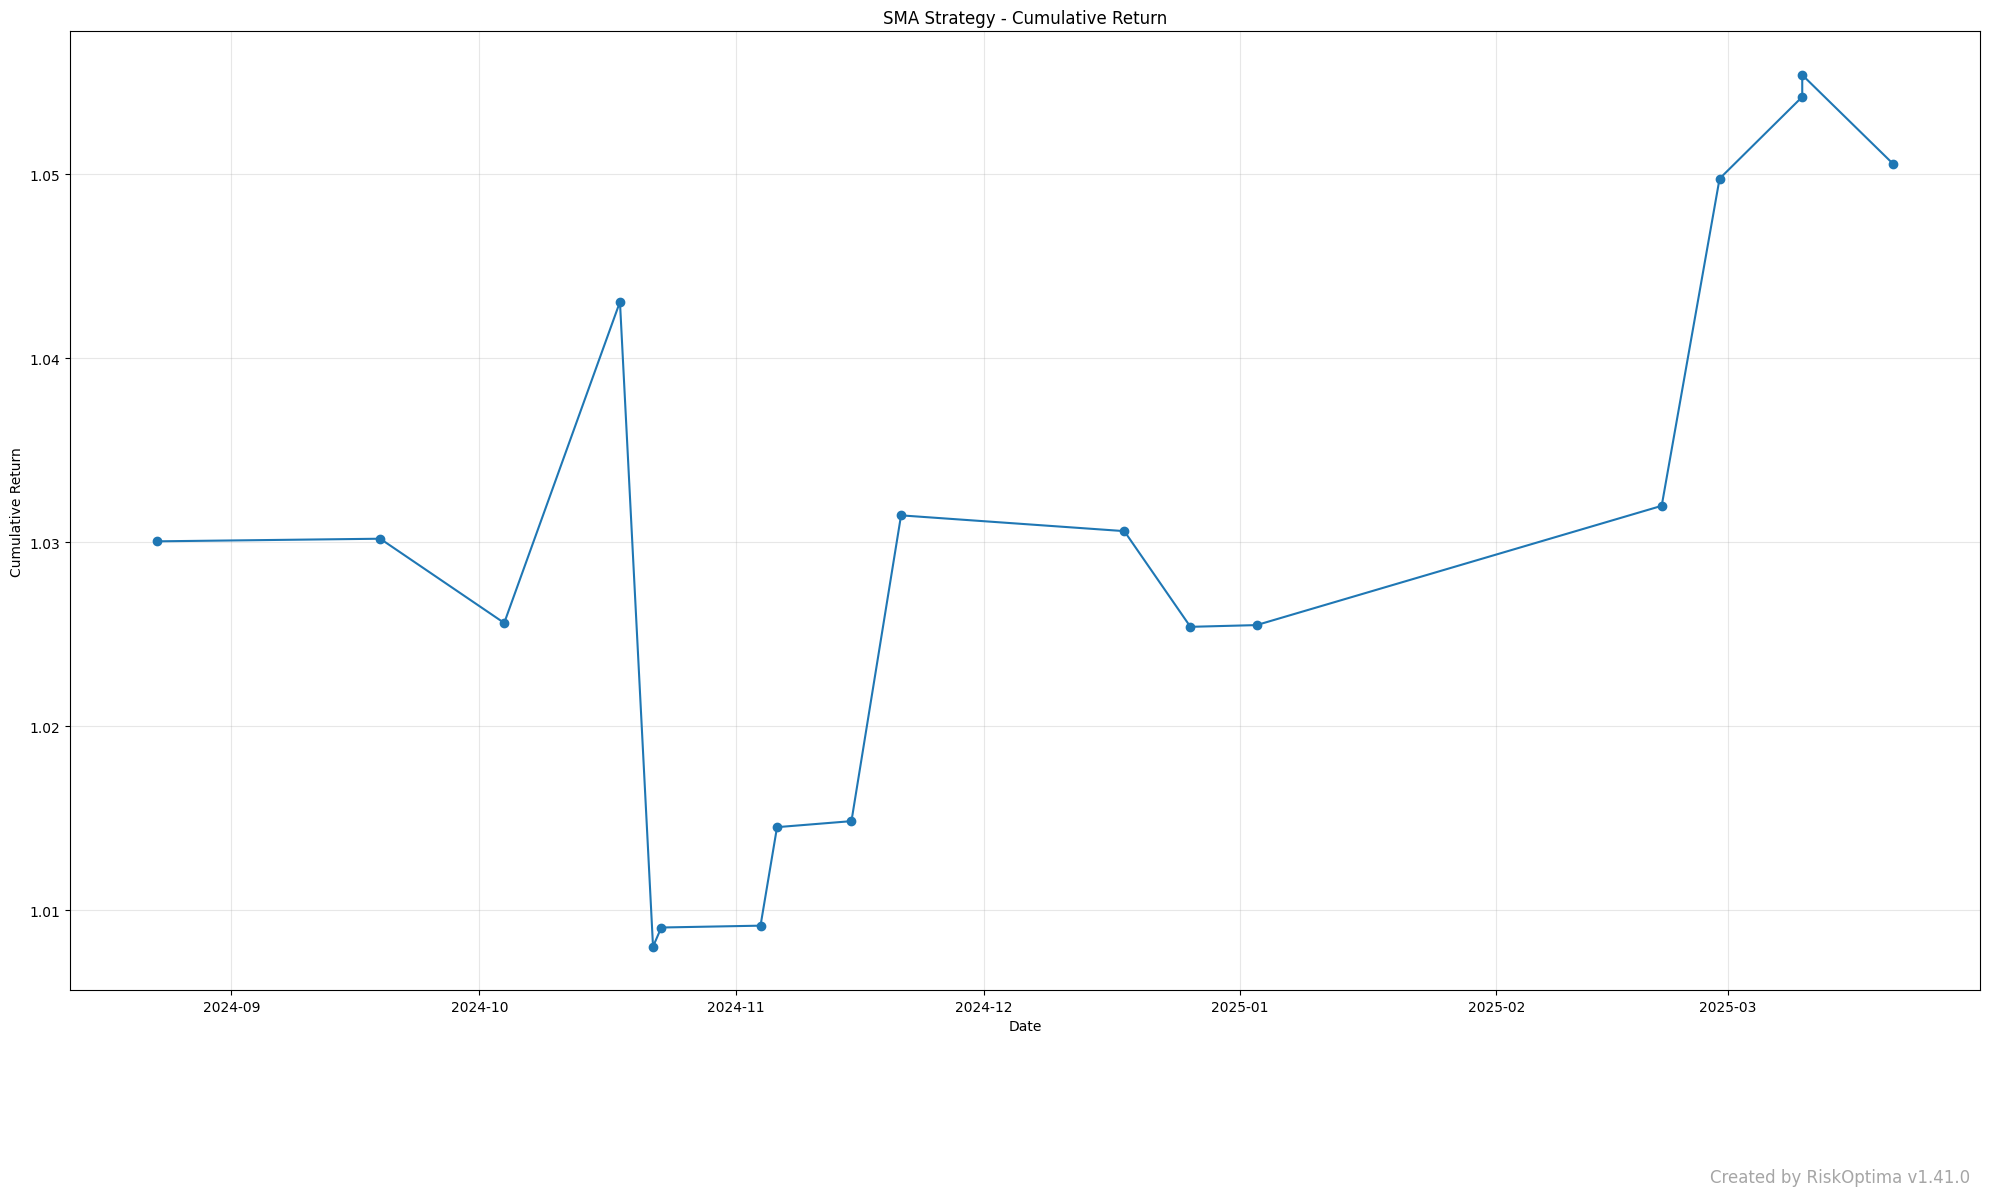

,Ticker,Entry Date,Exit Date,Entry Price,Exit Price,Return,Exit Reason,Weight,Weighted Return
0,FRT,2024-07-11,2024-08-23,102.904900,113.947586,0.107310,Take Profit,0.28,0.030047
0,MSEX,2024-07-17,2024-11-06,61.294102,67.796951,0.106093,Take Profit,0.05,0.005305
0,BKH,2024-07-19,2024-11-04,55.800865,56.357246,0.009971,Sell Signal,0.01,0.000100
0,NFG,2024-07-19,2024-10-18,56.490379,62.497425,0.106338,Take Profit,0.16,0.017014
0,NWN,2024-07-22,2024-11-21,38.217239,42.687080,0.116959,Take Profit,0.14,0.016374
0,ED,2024-07-30,2024-10-23,95.668594,105.536224,0.103144,Take Profit,0.01,0.001031
0,PEP,2024-08-02,2024-10-04,173.667252,165.092209,-0.049376,Sell Signal,0.09,-0.004444
0,GPC,2024-08-06,2024-09-19,136.776840,136.894577,0.000861,Sell Signal,0.16,0.000138
1,GPC,2024-10-18,2024-10-22,140.859543,111.284645,-0.209960,Sell Signal,0.16,-0.033594
1,BKH,2024-11-08,2024-11-15,59.468636,61.386349,0.032247,Sell Signal,0.01,0.000322


In [57]:
# Run for a single ticker
run_and_plot_sma_strategy("SPY", ANALYSIS_START_DATE, ANALYSIS_END_DATE, stop_loss=0.05, take_profit=0.10)

# Run for multiple tickers (equal weights)
run_and_plot_sma_strategy(["SPY", "AAPL", "KO"], ANALYSIS_START_DATE, ANALYSIS_END_DATE, stop_loss=0.05, take_profit=0.10)

# Run using your custom portfolio DataFrame (with weights)
run_and_plot_sma_strategy(asset_table, ANALYSIS_START_DATE, ANALYSIS_END_DATE, stop_loss=0.05, take_profit=0.10)